{[Click here to read this notebook in Google Colab](https://colab.research.google.com/drive/1vj-uML59d9ikjTSfOBt-ELRXlUtgweU_)}

<head><link rel = "stylesheet" href = "https://drive.google.com/uc?id=1zYOH-_Mb9jOjRbQmghdhsmZ2g6xAwakk"></head>

<table class = "header"><tr>
    <th align = "left">EPAT Batch 45 | Final Project, July 2020</th>
    <th align = "right">Written by: Gaston Solari Loudet</th>
</tr></table>

## "Backtest" class

Along the course, we've seen multiple utilities related to trading strategy backtesting. Most of them were vectorized and aimed towards measuring strategy returns as profit measurement, based in the price change of a chosen financial instrument. Most strategies were conceived as compound capitalizing: meaning that the investment fraction or "trade size" would always increase/decrease according to capital evolution. This, implying that trade efficacy is always in the same line as financial earnings.

One objective that I've got with this work, is to show that both variables **can** and **should** be analyzed separately. One could say that an adequate risk management method is enough to make a certain trading model to be profitable. However, a <u>trading strategy is good when its predictive capability is good</u>, and that should be our first line of defense. Think about it: Our main task as traders is to predict future price movement as accurate as we can. So our real edge is to accumulate the most predicted price movements.

That's why this ``Backtest`` class intends to design a 100% object-oriented framework, completely procedural and sequential, which evaluates price movement predictions first, and only after that, it gives a financial point of view to it. Also, main focus is along the line of <u>retail trading</u>, so we will pay attention to numerous aspects about it, such as occupied margin, free margin, margin level, broker leverage, trade sinking, and trading frequency.

The following cell downloads certain libraries we'll be using, in case it's not already included in this environment. Consider that this class will be importable outside this Jupyter Notebook, so in case the ``Backtest`` class is to be used outside from here, these libraries must be installed in a separate way. Though, it would be a nice idea to include a "``pip install``" file in the future that downloads every needed external module, if this task was to ever reach open-source applicability, and become a PyPi package.

In [ ]:
# Check if MetaTrader5 and ipynb stuff is importable in this Python.
import pip, sys, subprocess
reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed_libs = [r.decode().split('==')[0] for r in reqs.split()]
for lib in ["MetaTrader5", "ipynb", "yfinance"]:
    if lib not in installed_libs:
        print(lib, "library not installed yet. Downloading/installing it...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib])

### Introduction & imports

Let's see... the following 3 modules will be used as historical market data sources:
* "**``MetaTrader5``**": Actually a Python module for the software that I personally use for trading. MetaTrader is the most used **free** platform in retail trading around the world. Most popular leveraging brokers offer their own adaptation of it. There are 2 versions:
<br>➔ [MT4](https://www.metatrader4.com/en): The most widespread, focused on Forex, CFDs and Crypto nowadays. Though it offers an internal C++ IDE for algorithmic trading, it does not have Python functionalities of its own, but there are some open-source works that can accomplish all the needed functionalities, such as [Darwinex's](https://github.com/darwinex/dwx-zeromq-connector) [ZeroMQ](https://www.youtube.com/watch?v=3nM0c2kG_Sw).
<br>➔ [MT5](https://www.metatrader5.com/en): A bit less popular, due to being more focused into algorithmic trading, Futures and Indices. It has recently launched its own official [Python wrapper](https://www.mql5.com/en/docs/integration/python_metatrader5) in October 2019. Though it doesn't have real-time market access or automated live data streaming functions, we can give it a good use as a free market data source. Notice that <u>to be able to use this package, we need MT5</u> installed in our system, together with a valid demo broker account that offers such software. Otherwise, it won't work.
* "**``yfinance``**": [Yahoo! Finance](https://github.com/ranaroussi/yfinance)'s API for market data downloading. Though it does not offer more data precision than at daily frequency, it may be useful for testing swing trading strategies or when not having MT5 installed.

Other (pretty standard) stuff we'll need:
* "``numpy``", "``pandas``" and "``itertools``": Mathematical operations for numerical arrays and tables.
* "``pytz``" and "``datetime``": Timezone and calendar time data manipulation.
* "``scipy.stats``": For quite a few statistical calculations around Normal distribution.
* "``matplotlib``": Visual representation library. Graph and plot handling.

In [ ]:
%%capture
# Other function packages.
import numpy, pandas, pytz, datetime, matplotlib, matplotlib.pyplot, itertools
import scipy.stats, yfinance, ipynb, MetaTrader5
# Preset (dark) plot properties.
matplotlib.pyplot.style.use("https://drive.google.com/uc?id=1TawPXELPzNlySaOx3HT67A-wHwRxuWjQ")
pandas.plotting.register_matplotlib_converters()
pandas.options.display.max_columns = None
colors = matplotlib.cm.ScalarMappable()

<hr>

### Attributes

The class will be largely based in 4 dataframes:
* "``.Data``": Will deal with "time-series" data types: market price/volume data, indicators and trading signals.
<br>&ensp;Notice that it is a double-layered dataframe: there is one block of columns per backtested instrument.
* "``.Active``": Intended to hold info about open positions as backtesting timeline proceeds, until their exit.
* "``.Trades``": List of closed trades and their outcomes, like one would see in a trading platform.
* "``.Specs``": For storing specific details related to the traded instrument: contract size, point value, etc.
* "``.Stats``": Akin to "``pandas.DataFrame.summary``" method, but with some additional "financial" aspects.

The "``.name``" string just serves as an identifier so as to be able to work with multiple "``Backtest``" instances at the same time.

In [ ]:
class Backtest(object):
    max_rows = 5000
    def __init__(self, name = "Strategy"):
        df, pm, self.name = pandas.DataFrame, pandas.MultiIndex, name
        self.Data = df(columns = pm.from_tuples(tuples = [], names = ("Symbol", "Value")))
        self.Active = df(columns = ["Time", "Price", "Sym", "Dir", "Size", "Sink", "SL", "SP"])
        self.Trades = df(columns = pm.from_product(iterables = [("Time", "Price"), ("Open", "Close")]))
        for c in ("Sym", "Dir", "Size", "Sink", "Cause"): self.Trades[c] = None
        self.Specs, self.Stats = df(), df()

It is useful to add a "``__repr__``" keyword feature so that when we ``print`` a certain instance, one of those dataframe attributes will be showed up. Whether one or the other is shown, depends on the state of progress that the backtesting is actually on. More of this will be elaborated on in upcoming sections.

From now onwards, the class will be constantly updated with the upcoming features by use of these "``super()``" methods. When repeatedly written in the class constructor, this "overwrites" the past definition with itself plus the new functions. This avoids needing to write the whole class code in one single cell, while being able to intercalate text cells in between.

In [ ]:
from IPython.display import display
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def __repr__(self):
        print(f"Strategy ID: '{self.name}'")
        if not self.Stats.empty: display(self.Stats)
        elif not self.Trades.empty: display(self.Trades)
        else: display(self.Data)
        return

As seen on the next code cell, every important function will have an "``_error``" section associated, so as to be able to interrupt its execution when input parameters are invalid. It will be added to the class in separate cells, however. Like this, we avoid needing to add numerous "``assert``" lines in the function description itself. Functions with a leading underscore ("``_``") are coded as "internal methods" not to be run outside from class, like usually standardized nowadays.

<hr>

### Market data download

So for retrieval of market data belonging to a certain instrument, we usually need at least 4 pieces of information:

1. "``symbol``" (string): The identifier that the broker uses to designate the instrument inside its portfolio. <br>We will allow a "``set``" of them as input, enabling multi-instrument strategies.
2. "``frame``" (string): Time step "<u>XY</u>" where "<u>X</u>" is the unit of measurement, and "<u>Y</u>" is the amount per row.<br>(Usually used in manual trading. <u>E.g.</u>: "M15" means 15 minutes per row, "H4" means 4 hours per row, etc.).
3. "``date``" (datetime): Last date in the dataframe. MetaTrader creates the history dataframe <u>backwards</u>.
4. "``rows``" (integer): How many of them will "``.Data``" hold. We'll limit such by a certain "``max_rows``" to avoid overcharging our RAM.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"):
        super().__init__(name = name)
    def _load_data_error(symbols, dates, frame, source):
        sources, dt, array_types = ["MT5", "yfinance"], datetime.timedelta, (set, tuple, list, str)
        assert isinstance(symbols, array_types), "{TYPE} 'symbols' must be a string label or an array of them."
        assert isinstance(frame, str), "{TYPE} 'frame' must be given as a string on one of MT5 enum labels."
        assert isinstance(dates, (list, tuple, numpy.ndarray)) and isinstance(dates[-1] - dates[0], dt) and \
               (len(dates) == 2) and  "{TYPE} 'dates' must be a list or tuple of only 2 'datetime' objects."
        assert (source in sources), "{COND} 'source' must be between the ones available: '%s'" % sources

Our main subject in this phase is the "``load_data``" method which gets these arguments and after some suitable rearrangement (e.g.: assuring the symbol input to be given as a set of "``{symbols}``"), it goes on to complete our "``.Data``" and "``.Specs``" dataframes with that last line. Each function will be described in the cells that follow. Downloaded data is later "cleaned" and coupled with the neighbouring instruments by means of the "``interpolate``" and "``dropna``" functions, to make sure no "``NaN``" market prices/volumes are left.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def load_data(self, symbols, dates = None, frame = "M5", source = "yfinance"):
        t, dt = datetime.datetime.now(), datetime.timedelta(days = 15)  
        if (dates == None): dates = (t - dt, t)  ## By default, use last 15 days' data in store.
        Backtest._load_data_error(symbols, dates, frame, source)  ## Check that all inputs are right.
        if isinstance(symbols, str): symbols = {symbols}  ## We'll use set methods: assure 'symbols' is a set.
        self._download_specs(symbols, source)  ## Download symbols' constants and append to "Specs" dataframe.
        self._download_data(symbols, dates, frame, source)  ## Download symbols' market data and add to "Data".
        self.Data.interpolate(inplace = True)  ## Complete NaN values with linearly interpolated data.
        self.Data.dropna(inplace = True, how = "all")  ## Delete rows with any residual NaN value.

We look for the corresponding "``data``" of each symbol and then add it to the "``.Data``" attribute with the upcoming "``_load_data_set``" underscored function. At first, downloaded "``data``" is a "``numpy``" array with labels, so it must be turned into a "``pandas.DataFrame``" object.
* Given MetaTrader 5 is installed (True "``.isMT``"), we use the "``frame``" string to retrieve the corresponding "``enum``" (labelled integer) value that the platform uses to identify the timeframe. We then proceed to download the market data with the "<code>[copy_rates_from](https://www.mql5.com/en/docs/integration/python_metatrader5/mt5copyratesfrom_py)</code>" wrapper function.
* If MetaTrader 5 is **not** installed, the dataframe is downloaded from my [GitHub repository] for this task. Hence, this code will only work when applying certain symbols and time intervals whose spreadsheets are stored in it. Check the repo content for more info. Know however, that such "``csv``" files had been indeed downloaded from MetaTrader.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _download_data(self, symbols, dates, frame, source):
        for symbol in symbols:
            assert isinstance(symbol, str), "{TYPE} each 'symbol' in set must be a string and included in MT5."
            if (source == "MT5") and MetaTrader5.initialize(): ## If MT5 is installed and expressed as source...
                enum = eval(f"MetaTrader5.TIMEFRAME_{frame}") ## Find int value in MT5 module attached to frame.
                data = MetaTrader5.copy_rates_range(symbol, enum, *dates) ## Download market data of the symbol.
                data = pandas.DataFrame(data).iloc[:, 0, 1, 2, 3, 4, 7, 6] ## Get DF of it & drop "tick_volume".
                data["time"] = pandas.to_datetime(data["time"], unit = "s") ## Convert time values to datetime.
                data.set_index(inplace = True, keys = "time", drop = True) ## Set datetime values as index.
            else: # if (source == "yfinance"): ...or any other source that we'd treat as default...
                enum = "".join([_ for _ in frame if _.isdigit()]) \
                     + "".join([x for x in frame if not x.isdigit()]) ## "H4" in MT5 is "4h" in yfinance.
                data = yfinance.download(tickers = symbol, rounding = True,
                       interval = enum.lower(), start = dates[0], end = dates[1]) ## Download market data.
                data = data.iloc[:, [0, 1, 2, 4, 5]]  ;  data["spread"] = 0 ## Drop "Close" column (use "Adj") &
            self._stack(data, symbol, frame) ## Add result to database.     ## create/fill "Spread" column w/0s.

After retrieving the instrument's dataframe, we "``_stack``" its columns to the "``.Data``" spreadsheet.
Notice that:

1. ``Spread`` values which are retrieved in point units, are converted to price fractions.
2. "**OHLCV**" stands for "``Open``", "``High``", "``Low``", "``Close``" and "``Volume``" variables.
<br>&emsp;&ensp;For each downloaded symbol/frame, there will be one set of these columns.
3. We will consider that 2 downloads of the same symbol but different time``frame``s, are 2 totally different datasets.<br>&emsp;&ensp;As an example: "``EURUSD M5``" and "``EURUSD H1``" will have a separate set of "**OHLCV**s" of their own.
4. Those "<u>``LB``</u>", "<u>``SS``</u>", "<u>``LS``</u>" and "<u>``SB``</u>" columns are associated with future ``L``ong/``S``hort/``B``uy/``S``ell signals.
<br>&emsp;&ensp;We'll get into more detail later. But consider one set of these <u>per symbol</u> (not per symbol/frame).


In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"):
        super().__init__(name = name)
    def _stack(self, data, symbol, frame):
        point = self.Specs[symbol].loc["point"] ## Retrieve how much is a symbol's "point" worth in its price.
        data["spread"] = data["spread"]*point  ## Spreads often come expressed in points. Measure them in price.
        data = data.round(self.Specs[symbol].loc["digits"]) ## Round prices with standard amount of decimals.
        OHLCV = ["Open", "High", "Low", "Close", "Volume"] ## Each price dataset will always have these columns.
        for c, column in enumerate(OHLCV): ## Create a data section in dataframe for each symbol-frame dataset.
            self.Data[(f"{symbol} {frame}", column)] = data.iloc[:, c] ## Add each of the columns to section.
        self.Data[(symbol, "Spread")] = data["spread"] ## Create a signal section in dataframe for each symbol.
        for column in ("LB", "SS", "LS", "SB"): self.Data[(symbol, column)] = None ## Add signal columns.

In parallel, the "``_download_specs``" method does the same job as the underscored "``_download_data``", but downloading a single-column sheet that holds certain instrument constants which is added to the "``.Specs``" database for all instruments. This is only possible for those downloaded from MetaTrader 5 because the platform can provide them. When downloading from Yahoo! Finance, we can just force these constant values, knowing that most Yahoo symbols' prices are rounded to 2 digits.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _download_specs(self, symbols, source):
        for symbol in symbols:
            if (source == "MT5") and MetaTrader5.initialize(): ## If MT5 is installed and expressed as source...
                specs = MetaTrader5.symbol_info(symbol)._asdict() ## Retrieve symbol specifications as dict.
                self.Specs[symbol] = specs.values() ## Create a column for every symbol, and add its constants.
                self.Specs.index = specs.keys() ## Use rows as each specification description/tag.
            else: ## Let's "invent" the specifications we will really need.
                self.Specs[symbol] = None
                self.Specs.loc["point", symbol] = 0.01
                self.Specs.loc["digits", symbol] = 2
                self.Specs.loc["trade_tick_size", symbol] = 0.01
                self.Specs.loc["trade_tick_value", symbol] = 1.0
                self.Specs.loc["trade_stops_level", symbol] = 0.01

To delete any instrument that was added by mistake, we could just use the "``pandas.DataFrame.drop``" function and its "``inplace``" argument.<br>But we need to do in both "``.Data``" and "``.Specs``", so...

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def drop_data(self, symbol):
        assert isinstance(symbol, str), "{TYPE} 'symbol' must be given as string, and formerly loaded."
        myTest.Specs.drop(columns = [symbol], inplace = True)  ## Delete symbol column from specs.
        columns = [c for c in self.Data.columns if symbol in c[0]]  ## Get every column name in Data that is...
        myTest.Data.drop(columns = columns, inplace = True)         ## ...related to the symbol, & delete them.
        myTest.Data.dropna(inplace = True, how = "all") ## Delete any residual NaN that appeared in the process.

**<u>Finally</u>**, let's give a try to the class and its "``load_data``" function.<br>Taking advantage of the "``__repr__``" dunder, we can ``print`` our instance and display its downloaded "``.Data``".<br>Note the disposition of the columns and the time indexes.

In [ ]:
symbol = "AAPL"
# ------------------------------------------------------
def myTest_unit_1(myTest):
    myTest.load_data(symbols = {symbol}) # "TSLA"})
    # myTest.drop_data(symbol = "TSLA")
# ------------------------------------------------------ Let's try.
myTest = Backtest(name = "A certain strategy")
myTest_unit_1(myTest)
myTest.Data.to_csv(path_or_buf = "myTest_Data.csv")
myTest.__repr__() ## Verbose

[*********************100%***********************]  1 of 1 completed
Strategy ID: 'A certain strategy'


Symbol                    AAPL M5                                    AAPL  \
Value                        Open    High     Low   Close   Volume Spread   
Datetime                                                                    
2020-08-10 09:30:00-04:00  450.40  451.96  449.89  451.08  3806795    0.0   
2020-08-10 09:35:00-04:00  451.07  453.12  451.01  452.38  1512286    0.0   
2020-08-10 09:40:00-04:00  452.40  454.98  452.35  454.69  1593656    0.0   
2020-08-10 09:45:00-04:00  454.73  455.10  451.83  451.93  1461814    0.0   
2020-08-10 09:50:00-04:00  451.90  452.74  449.71  450.77  1483560    0.0   
...                           ...     ...     ...     ...      ...    ...   
2020-08-21 15:35:00-04:00  495.95  496.96  495.08  496.94  1292128    0.0   
2020-08-21 15:40:00-04:00  496.95  497.03  494.50  495.27  1314197    0.0   
2020-08-21 15:45:00-04:00  495.26  497.62  495.19  496.94  1340518    0.0   
2020-08-21 15:50:00-04:00  496.94  498.57  496.86  498.39  1457792    0.0   
2020-08-21 15:55:00-04:00  498.38  499.19  497.36  497.40  2278088    0.0   

Symbol                                             
Value                        LB    SS    LS    SB  
Datetime                                           
2020-08-10 09:30:00-04:00  None  None  None  None  
2020-08-10 09:35:00-04:00  None  None  None  None  
2020-08-10 09:40:00-04:00  None  None  None  None  
2020-08-10 09:45:00-04:00  None  None  None  None  
2020-08-10 09:50:00-04:00  None  None  None  None  
...                         ...   ...   ...   ...  
2020-08-21 15:35:00-04:00  None  None  None  None  
2020-08-21 15:40:00-04:00  None  None  None  None  
2020-08-21 15:45:00-04:00  None  None  None  None  
2020-08-21 15:50:00-04:00  None  None  None  None  
2020-08-21 15:55:00-04:00  None  None  None  None  

[780 rows x 10 columns]

<hr>

### Indicators & Signals

The central idea would be for the class user to code their indicators and entry/exit conditions on top of the "``.Data``" object. Building separate functions for these subjects would be a bit useless because the central object of this section is their addition to the market dataframe and nothing more. Afterwards, we'd build separate functions for strategy execution itself.

Let's suppose that based on our downloaded data, we wish to apply a typical band momentum scalper with the following indicators:

1. Exponential envelopes; of window "``Env["Window"]``" and deviation "``Env["Deviation"]``".
<br>&emsp;&ensp;Upper "``Env_H``" (calculated on "``Low``") and lower "``Env_L``" (calculated on "``High``").
2. "n" standard deviations; "``StDv*n``" of window "``StDv[Window]``" (calculated on wick width "``High`` - ``Low``").

We will be simulating July-expiring E-micro S&P 500 with a 5-minute timeframe in AMP Brokers, so we calculate these in our chosen datasets (default: the leftmost "``[0][0]``" one in our dataframe).

In [ ]:
dataset = myTest.Data.columns[0][0]
Env = { "Window": 20, "Deviation": 0.005 } ; StDev = { "Window": 80 , "Number": 2}
n = StDev["Number"] ## Short for "amount of standard deviations in indicator"
# ----------------------------------------------------------------
def myTest_unit_2(myTest):
    myTest_unit_1(myTest)
    # Envelopes
    myTest.Data[("Indicators", "Env_L")] = myTest.Data[(dataset, "High")].ewm(span = Env["Window"]).mean()
    myTest.Data[("Indicators", "Env_L")] = myTest.Data[("Indicators", "Env_L")]*(1 - Env["Deviation"])
    myTest.Data[("Indicators", "Env_H")] = myTest.Data[(dataset,  "Low")].ewm(span = Env["Window"]).mean()
    myTest.Data[("Indicators", "Env_H")] = myTest.Data[("Indicators", "Env_H")]*(1 + Env["Deviation"])
    # Standard deviation
    myTest.Data[("Indicators", "Wick")]  = myTest.Data[(dataset, "High")] - myTest.Data[(dataset, "Low")]
    myTest.Data[("Indicators", "StDv*%d" % n)] = myTest.Data[("Indicators", "Wick")]\
                                                 .rolling(StDev["Window"]).std()*n
# ------------------------------------------------------ Let's try.
myTest = Backtest(name = "A certain strategy")
myTest_unit_2(myTest)
myTest.Data.to_csv(path_or_buf = "myTest_Data.csv")
myTest.__repr__() ## Verbose

[*********************100%***********************]  1 of 1 completed
Strategy ID: 'A certain strategy'


Symbol                    AAPL M5                                    AAPL  \
Value                        Open    High     Low   Close   Volume Spread   
Datetime                                                                    
2020-08-10 09:30:00-04:00  450.40  451.96  449.89  451.08  3806795    0.0   
2020-08-10 09:35:00-04:00  451.07  453.12  451.01  452.38  1512286    0.0   
2020-08-10 09:40:00-04:00  452.40  454.98  452.35  454.69  1593656    0.0   
2020-08-10 09:45:00-04:00  454.73  455.10  451.83  451.93  1461814    0.0   
2020-08-10 09:50:00-04:00  451.90  452.74  449.71  450.77  1483560    0.0   
...                           ...     ...     ...     ...      ...    ...   
2020-08-21 15:35:00-04:00  495.95  496.96  495.08  496.94  1292128    0.0   
2020-08-21 15:40:00-04:00  496.95  497.03  494.50  495.27  1314197    0.0   
2020-08-21 15:45:00-04:00  495.26  497.62  495.19  496.94  1340518    0.0   
2020-08-21 15:50:00-04:00  496.94  498.57  496.86  498.39  1457792    0.0   
2020-08-21 15:55:00-04:00  498.38  499.19  497.36  497.40  2278088    0.0   

Symbol                                             Indicators              \
Value                        LB    SS    LS    SB       Env_L       Env_H   
Datetime                                                                    
2020-08-10 09:30:00-04:00  None  None  None  None  449.700200  452.139450   
2020-08-10 09:35:00-04:00  None  None  None  None  450.306155  452.730390   
2020-08-10 09:40:00-04:00  None  None  None  None  451.187033  453.421214   
2020-08-10 09:45:00-04:00  None  None  None  None  451.659745  453.614037   
2020-08-10 09:50:00-04:00  None  None  None  None  451.373479  453.213589   
...                         ...   ...   ...   ...         ...         ...   
2020-08-21 15:35:00-04:00  None  None  None  None  493.421201  496.858993   
2020-08-21 15:40:00-04:00  None  None  None  None  493.528215  496.869803   
2020-08-21 15:45:00-04:00  None  None  None  None  493.680947  496.945627   
2020-08-21 15:50:00-04:00  None  None  None  None  493.909157  497.174072   
2020-08-21 15:55:00-04:00  None  None  None  None  494.174385  497.428617   

Symbol                                     
Value                      Wick    StDv*2  
Datetime                                   
2020-08-10 09:30:00-04:00  2.07       NaN  
2020-08-10 09:35:00-04:00  2.11       NaN  
2020-08-10 09:40:00-04:00  2.63       NaN  
2020-08-10 09:45:00-04:00  3.27       NaN  
2020-08-10 09:50:00-04:00  3.03       NaN  
...                         ...       ...  
2020-08-21 15:35:00-04:00  1.88  1.207243  
2020-08-21 15:40:00-04:00  2.53  1.210008  
2020-08-21 15:45:00-04:00  2.43  1.229461  
2020-08-21 15:50:00-04:00  1.71  1.218644  
2020-08-21 15:55:00-04:00  1.83  1.205486  

[780 rows x 14 columns]

Remember our consensus about two datasets of same ``symbol`` different time``frame`` being considered as separate column blocks in our "``.Data``" structure? For example, "``AAPL M5``" and "``AAPL M15``" having different ``OHLCV``s. The main reason for such conception is the fact that calculations may be based on a certain ``frame`` (for example, "**M15**"), but one might prefer our trading events such as signals, entry trades and stop value crossings to happen (say **M1**) to increase data granularity and hence, backtesting precision (even perhaps avoiding disadvantages such as opposite signals at the same time).

This is quite useful in simulating a **relatively** high frequency trading strategy that would work in some platforms (such as MetaTrader 5 itself), where though one can request for tick data, standard indicators can only be set at a minimum of **M1**.

So it's important to identify the data at a maximum resolution to trigger signals and stops. We should first code a function that receives a certain instrument and ``_check``s which is the ``_min``imum available time``_frame`` in our "``.Data``". Remember that a dataset is usually labelled by the ``symbol`` name as prefix, and the timeframe codename as suffix. So the ``header`` is first ``.split`` and the suffix is later ``eval``uated as an enum. The rest of the function is just a typical "find-the-smallest" comparison routine.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _check_min_frame(self, symbol):
        f_min, n_min = "MN1", 50000  ### Max available frame.
        for column in myTest.Data.columns:
            header = column[0].split(" ")  ### Symbol name
            if (symbol in column[0]) and (len(header) > 1):
                f_new = header[1]  ### Header suffix (timeframe)
                n_new = eval(f"MetaTrader5.TIMEFRAME_{f_new}")
                if (n_new < n_min): n_min, f_min = n_new, f_new
        return f_min

Now, remember those 2-letter columns which remained yet to describe?
<br>Those were **signal** columns. There are 4 "``dire``ctions" for each instrument:
<center><table class = "square">
    <tr>  <th> Trade type  </th>  <th><u>Entry action</u></th>  <th><u>Exit action</u></th>  </tr>
    <tr>  <th> Long ("L")  </th>  <td> Long buy ("LB")   </td>  <td> Long sell ("LS") </td>  </tr>
    <tr>  <th> Short ("S") </th>  <td> Short sell ("SS") </td>  <td> Short buy ("SB") </td>  </tr>
</table></center>

We shall now include a "``load_signal``" function to complete our **signal** columns next to our "``.Data``".
<br>But what do we need to recognize the moment a long/short signal is emitted? At least <u>4 things</u>:
* The ``symbol`` for which we want to settle our signal principle.
* A trade ``dire``ction type, of those 4 labels above.
* An execution ``rule``: based on OHLCV prices and indicators.
* A certain price value which ``trig``gers it.

We shall discuss about the 5th ``bool``ean parameter "``strict``" in a few moments.<br>But before going on, the "``_error``" check function as always.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _load_signal_error(self, symbol, dire, trig, rule, shift, strict):
        assert (symbol in self.Data.columns), "{INCL} 'symbol' must be included in the available data."
        assert isinstance(trig, tuple), "{TYPE} 'trig' must be a string label of a block column in data."
        assert (trig in self.Data.columns), "{INCL} 'trig' dataset must be included in the available data."
        dirs = ("LB", "SS", "LS", "SB")
        assert isinstance(dire, str), "{TYPE} 'dire' must be given as a two-letter string: LB/SS/LS/SB."
        assert (dire in dirs), "{INCL} 'dire' must be equal to any of the trading signal types: LB/SS/LS/SB."
        assert isinstance(rule, type(lambda: 1)), "{TYPE}: Rule functions must be 'lambda' or 'def' objects."
        assert isinstance(strict, bool), "{TYPE} 'strict' is a boolean flag. Please, use 'True' or 'False'."
        assert isinstance(shift, int) and (shift >= 0), "{COND} 'shift' must be a positive integer."

Let's describe each argument and it's necessary data ``type``.

1. The ``symbol`` to trade: Where do we want to enter a position?
<br>&emsp;&ensp;Obviously, it must be between the ones among our "``.Data``".
2. Trade ``dire``ction: Long or short? Entry signal or exit signal? Must be specified with a ``str``ing.
<br>&emsp;&ensp;Note: taking a {long | short} entry signal, means to {buy | sell}, and vice versa when exiting.
3. Execution ``rule``: A function formed by boolean operations on price and indicator values.
<br>&emsp;&ensp;We'll use ``lambda`` expressions with the "``.Data``" as argument, with "``[``column``]``" referencing.
4. The ``trig``gering value by which the trade would be executed, usually present in another column ("**OHLCV**" or ``indicator``). <br>&emsp;&ensp;**Must NOT** be outside from between "``High``" and "``Low``", obviously. Also they should be chosen "**honestly enough**". <br>&emsp;&ensp;(E.g.: Taking "``Low``"/"``High``" when going long/short without proof of them being predictable enough, it's sort of cheating...)
5. Is our signal ``strict`` enough to prioritize an exact ``trig``gering price over the ``rule`` condition? Let's see...

When we calculate a signal's ``price`` value, it must obviously be an existent price value within the time interval: between ``Low`` and ``High``. For example, let's say that we are studying a moving average crossover strategy. Our "``LB``" condition would require the price "$P$" to cross over a "$MA$" indicator at a certain time "$t$". The signal price would be "$MA(t)$" then. However, if the price is already way over ("$MA(t) < P_{LOW}(t)$"), what would our signal price need to be? Is the signal even valid?

The "``load_signal``" function may then need to require a "``strict``" parameter to decide if the signal is...
* ...<u>invalid</u> ("``strict = True``", default) because we consider the triggering price to be unreal. Then, the signal shall remain as a NaN tuple.
* ...<u>valid</u> ("``strict = False``") because the settling ``rule`` is respected anyway. Then, we have to take a certain signal price in range. Choosing the ``Close`` price would have the logic of the trade being supposedly executed once the row is processed in real life.

The function would then fill in the blanks in the signal column for the specified symbol and direction of trade. It will hold the ``price`` at which the signal would turn into a real trade. "``NaN``" means that no valid signal showed up.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def load_signal(self, symbol, dire, trig, rule, shift = 0, strict = True):
        self._load_signal_error(symbol, dire, trig, rule, shift, strict) ## Check if input arguments are OK.
        dataset = symbol + " " + self._check_min_frame(symbol) ## Get symbol's dataset with most precision.
        signal = self.Data.apply(axis = "columns", func = rule).shift(shift) ## Apply rule function to dataset.
        prices = self.Data[trig].where(cond = signal.astype(bool)) ## If rule applies, get trig value. Else NaN.
        invalids = (prices < self.Data[dataset]["Low"]) | (self.Data[dataset]["High"] < prices) # Beyond range.
        # If strict flag on, signals with invalid triggers are turned to None. Else, trigger replaced by Close.
        prices.mask(inplace = True, cond = invalids, other = None if strict else self.Data[dataset]["Close"])
        self.Data[(symbol, dire)] = prices.round(self.Specs[symbol].loc["digits"]) ## Round to standard form.

So back to our "``myTest``" example, our strategy would contain the following entry conditions:
* <u>Main condition</u>: The ``Wick`` needs to be at least 2 standard deviations.
* <u>Enter long, "``LB``"</u>: High price ("``High``") over upper envelope ("``Env_H``").
* <u>Enter short, "``SS``"</u>: Low price ("``Low``") under upper envelope ("``Env_L``").
* <u>We'll be ``strict``</u> with the entry price always being the indicator-price crossing point.

In [ ]:
def myTest_unit_3(myTest):
    myTest_unit_2(myTest)
    myTest.load_signal( symbol = symbol, dire = "LB", trig = ("Indicators", "Env_H"), strict = True,
                        rule = lambda X: ( X[(dataset, "High")] > X[("Indicators", "Env_H")] ) \
                             * ( X[("Indicators", "Wick")] >= X[("Indicators", "StDv*%d" % n)]))  # Main.
    myTest.load_signal( symbol = symbol, dire = "SS", trig = ("Indicators", "Env_L"), strict = True,
                        rule = lambda X: ( X[(dataset, "Low")] < X[("Indicators", "Env_L")] ) \
                             * ( X[("Indicators", "Wick")] >= X[("Indicators", "StDv*%d" % n)])) # Main.
# ------------------------------------------------------ Let's try.
myTest = Backtest(name = "A certain strategy")  ;  myTest_unit_3(myTest)
myTest.Data.to_csv(path_or_buf = "myTest_Data.csv")  ;  myTest.__repr__() ## Verbose

[*********************100%***********************]  1 of 1 completed
Strategy ID: 'A certain strategy'


Symbol                    AAPL M5                                    AAPL  \
Value                        Open    High     Low   Close   Volume Spread   
Datetime                                                                    
2020-08-10 09:30:00-04:00  450.40  451.96  449.89  451.08  3806795    0.0   
2020-08-10 09:35:00-04:00  451.07  453.12  451.01  452.38  1512286    0.0   
2020-08-10 09:40:00-04:00  452.40  454.98  452.35  454.69  1593656    0.0   
2020-08-10 09:45:00-04:00  454.73  455.10  451.83  451.93  1461814    0.0   
2020-08-10 09:50:00-04:00  451.90  452.74  449.71  450.77  1483560    0.0   
...                           ...     ...     ...     ...      ...    ...   
2020-08-21 15:35:00-04:00  495.95  496.96  495.08  496.94  1292128    0.0   
2020-08-21 15:40:00-04:00  496.95  497.03  494.50  495.27  1314197    0.0   
2020-08-21 15:45:00-04:00  495.26  497.62  495.19  496.94  1340518    0.0   
2020-08-21 15:50:00-04:00  496.94  498.57  496.86  498.39  1457792    0.0   
2020-08-21 15:55:00-04:00  498.38  499.19  497.36  497.40  2278088    0.0   

Symbol                                             Indicators              \
Value                          LB  SS    LS    SB       Env_L       Env_H   
Datetime                                                                    
2020-08-10 09:30:00-04:00     NaN NaN  None  None  449.700200  452.139450   
2020-08-10 09:35:00-04:00     NaN NaN  None  None  450.306155  452.730390   
2020-08-10 09:40:00-04:00     NaN NaN  None  None  451.187033  453.421214   
2020-08-10 09:45:00-04:00     NaN NaN  None  None  451.659745  453.614037   
2020-08-10 09:50:00-04:00     NaN NaN  None  None  451.373479  453.213589   
...                           ...  ..   ...   ...         ...         ...   
2020-08-21 15:35:00-04:00  496.86 NaN  None  None  493.421201  496.858993   
2020-08-21 15:40:00-04:00  496.87 NaN  None  None  493.528215  496.869803   
2020-08-21 15:45:00-04:00  496.95 NaN  None  None  493.680947  496.945627   
2020-08-21 15:50:00-04:00  497.17 NaN  None  None  493.909157  497.174072   
2020-08-21 15:55:00-04:00  497.43 NaN  None  None  494.174385  497.428617   

Symbol                                     
Value                      Wick    StDv*2  
Datetime                                   
2020-08-10 09:30:00-04:00  2.07       NaN  
2020-08-10 09:35:00-04:00  2.11       NaN  
2020-08-10 09:40:00-04:00  2.63       NaN  
2020-08-10 09:45:00-04:00  3.27       NaN  
2020-08-10 09:50:00-04:00  3.03       NaN  
...                         ...       ...  
2020-08-21 15:35:00-04:00  1.88  1.207243  
2020-08-21 15:40:00-04:00  2.53  1.210008  
2020-08-21 15:45:00-04:00  2.43  1.229461  
2020-08-21 15:50:00-04:00  1.71  1.218644  
2020-08-21 15:55:00-04:00  1.83  1.205486  

[780 rows x 14 columns]

The <u>exit conditions</u> would be the opposite: {``L``ong ``S``elling | ``S``hort ``B``uying} executes when new {``S``hort ``S``elling | ``L``ong ``B``uying} conditions appear. There's no need to use the "``_load_signal``" function in this case: we could just copy and relabel the entry signal columns. We will consider the possibility of exiting a position both towards stop values ("``SL``" and "``SP``") and/or these "``Exit``" conditions. We will try to use both methodologies.

The <u>usefulness of exit signal values being numerical</u> and not ``bool``ean like the usual method, rests on the capability of the partial closes of trades. For example: getting a ``S``hort ``B``uy of size 1 while having opened a ``S``hort ``S``ell of size 3 a few moments ago, would imply clearing a third of the ongoing short, but not all of it.

In [ ]:
def myTest_unit_4(myTest):
    myTest_unit_3(myTest)
    myTest.Data[(symbol, "LS")] = myTest.Data[(symbol, "SS")]
    myTest.Data[(symbol, "SB")] = myTest.Data[(symbol, "LB")]
# ------------------------------------------------------ Let's try.
myTest = Backtest(name = "A certain strategy")
myTest_unit_4(myTest)
myTest.Data.to_csv(path_or_buf = "myTest_Data.csv")
myTest.__repr__() ## Verbose.

[*********************100%***********************]  1 of 1 completed
Strategy ID: 'A certain strategy'


Symbol                    AAPL M5                                    AAPL  \
Value                        Open    High     Low   Close   Volume Spread   
Datetime                                                                    
2020-08-10 09:30:00-04:00  450.40  451.96  449.89  451.08  3806795    0.0   
2020-08-10 09:35:00-04:00  451.07  453.12  451.01  452.38  1512286    0.0   
2020-08-10 09:40:00-04:00  452.40  454.98  452.35  454.69  1593656    0.0   
2020-08-10 09:45:00-04:00  454.73  455.10  451.83  451.93  1461814    0.0   
2020-08-10 09:50:00-04:00  451.90  452.74  449.71  450.77  1483560    0.0   
...                           ...     ...     ...     ...      ...    ...   
2020-08-21 15:35:00-04:00  495.95  496.96  495.08  496.94  1292128    0.0   
2020-08-21 15:40:00-04:00  496.95  497.03  494.50  495.27  1314197    0.0   
2020-08-21 15:45:00-04:00  495.26  497.62  495.19  496.94  1340518    0.0   
2020-08-21 15:50:00-04:00  496.94  498.57  496.86  498.39  1457792    0.0   
2020-08-21 15:55:00-04:00  498.38  499.19  497.36  497.40  2278088    0.0   

Symbol                                             Indicators              \
Value                          LB  SS  LS      SB       Env_L       Env_H   
Datetime                                                                    
2020-08-10 09:30:00-04:00     NaN NaN NaN     NaN  449.700200  452.139450   
2020-08-10 09:35:00-04:00     NaN NaN NaN     NaN  450.306155  452.730390   
2020-08-10 09:40:00-04:00     NaN NaN NaN     NaN  451.187033  453.421214   
2020-08-10 09:45:00-04:00     NaN NaN NaN     NaN  451.659745  453.614037   
2020-08-10 09:50:00-04:00     NaN NaN NaN     NaN  451.373479  453.213589   
...                           ...  ..  ..     ...         ...         ...   
2020-08-21 15:35:00-04:00  496.86 NaN NaN  496.86  493.421201  496.858993   
2020-08-21 15:40:00-04:00  496.87 NaN NaN  496.87  493.528215  496.869803   
2020-08-21 15:45:00-04:00  496.95 NaN NaN  496.95  493.680947  496.945627   
2020-08-21 15:50:00-04:00  497.17 NaN NaN  497.17  493.909157  497.174072   
2020-08-21 15:55:00-04:00  497.43 NaN NaN  497.43  494.174385  497.428617   

Symbol                                     
Value                      Wick    StDv*2  
Datetime                                   
2020-08-10 09:30:00-04:00  2.07       NaN  
2020-08-10 09:35:00-04:00  2.11       NaN  
2020-08-10 09:40:00-04:00  2.63       NaN  
2020-08-10 09:45:00-04:00  3.27       NaN  
2020-08-10 09:50:00-04:00  3.03       NaN  
...                         ...       ...  
2020-08-21 15:35:00-04:00  1.88  1.207243  
2020-08-21 15:40:00-04:00  2.53  1.210008  
2020-08-21 15:45:00-04:00  2.43  1.229461  
2020-08-21 15:50:00-04:00  1.71  1.218644  
2020-08-21 15:55:00-04:00  1.83  1.205486  

[780 rows x 14 columns]

<hr>

### Signal execution

Our "``.Data``" structure is built on a vectorized scheme. Despite this, it is convenient to simulate the strategy routine on a <u>**procedural manner**</u> so as to try and simulate the "market event handling" in a much more realistic way. It will be accomplished with the use of an archetypal "``for``" cycle. To prepare this framework for the future **true** backtesting process, we need to work on an essential element: a book of "``.Active``" trades.

1. Its main function is to allow the simultaneous time management on each of our trades from their cradle to the grave.
2. We'll elaborate on each "``.Active``" trade while traversing "``.Data``" rows, with their opening ``Time``, ``Price``, ``Dire``ction, and "``SL``"/"``SP``".
3. Usually in retail trading, profit or loss caused by a trade that's still not closed, are called "floating". We define the <u>``Sink``</u> as that <u>critical condition of an active trade in which the "floating" loss was ever the highest</u> (hence, the trade is ``Sink``ing).

Pretty similar to the drawdown concept, the ``Sink`` price is the farthest losing price that an active trade has reached. If {long | short}, its price is its {lowest | highest} ever. Being focused on simulating <u>retail</u> trading, we need this to locate those points in which we are risking the broker's leverage at most.

We will also incorporate the concept of **trade management functions** as "``lambda``" or "``def``" objects whose purpose is to define the specific details that a trading order would require, aside from the "price". For the time being, these are: trade ``size``, stop loss "``SL``" and stop profit "``SP``" calculators. A similar but more profound approach could give birth to functions which could calculate and set pending orders or even trailing stops (moving stop values).

But before going on, we will build 2 modular (internal, "``_``") functions to keep on with the "modular" philosophy of this code. **These will be the necessary building blocks to simulate the interaction with the market in the final backtesting process**.

#### [{A}] Trade execution ("``._check_new_trades``")

Every ``time`` a new piece of market data (``row`` in position given by ``index``) arrives, will check signals and register new trades if possible.

<u>Defaults</u>: ``symbol`` is the 1st that was loaded to the class instance, ``size`` is just one, and "``SL``"/"``SP``" are NaNs when they are not going to be used.

1. First of all, we retrieve the ``row`` of market history ``.Data`` and existing signals for given ``time``.
2. We check for new signals. If no new valid signal is present ("``NaN``"), return a "``False``" flag for each case (long "``op_L``" and short "``op_S``").
3. If no signals are present (both ``False`` flags) or there are 2 opposite signals (both ``True``), reject them and ``return`` to main code.
4. Once a valid signal has been found, get its direction (``L``ong or ``S``hort) and get its price value from the corresponding column in ``.Data``. 
5. Use the trade management functions for ``size``, "``SL``" and "``SP``" to determine their values for the upcoming trade. We will define them to be computable from the actual ``row`` (present price/indicator values) and the ongoing track record (already closed ``.Trades``)
6. Note that stop values must be at least equal to the minimum that the broker/instrument allows. Otherwise, reject them ("``NaN``").
7. Update "real" entry point: The ``Spread`` offsets the signal ``price`` towards the implied direction: add ("``L``") or subtract ("``S``").
8. Finally, extract all required info from the actual row and ``append`` trade to the "``.Active``" trade dataframe.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _check_new_trades(self, time, symbol = None, max_trades = 2, size = None, SL = None, SP = None):
        if (symbol == None): symbol = self.Data.columns[0][0].split(" ")[0] # Default: leftmost instrument.
        if (size == None): size = (lambda R, T: 1) # Default size 1. Both args must be there anyway.
        if (SL == None): SL = (lambda R, T: numpy.nan) # Every symbol should have SL & SP functions.
        if (SP == None): SP = (lambda R, T: numpy.nan) # READ CELL ABOVE FOR ARGUMENT DETAILS.
        if (len(self.Active) >= max_trades): return # If no space for more trades, just quit.
        row = self.Data.loc[time, :] # (1) Get all row/candle price/volume/signals' data for given time value.
        op_L, op_S = row[symbol][["LB", "SS"]].notna() ## (2) Check if any long/short signal.
        if (op_L == op_S): return # (3) Both signals invalid (F, F) or valid but opposite (T, T) -> quit.
        dire = "LB"*op_L + "SS"*op_S # (4) Either one or the other is True, so "dire" will be "LB" XOR "SS".
        price = row[symbol][dire] # (4) Retrieve price value which triggers the signal.
        size = numpy.abs(size(row, self.Trades))
        SL = numpy.abs(SL(row, self.Trades))  # (5) Run size, SL & SP function on available present info at...
        SP = numpy.abs(SP(row, self.Trades))  # ...given time (market & trades' context) and calc their value.
        min_dist = (self.Specs.loc["point"]*(1 + self.Specs.loc["trade_stops_level"])).max() # (6) Stop can't
        SL, SP = numpy.nan if (SL < min_dist) else SL, numpy.nan if (SP < min_dist) else SP # get nearer than 
        price = price + (op_L - op_S)*row[symbol]["Spread"] # (7) Spread to entry price.  # min_dist to price.
        self.Active = self.Active.append(ignore_index = True, other = { "Time": time,
            "Price": price, "Size": size, "Sink": price, "Sym": symbol, "Dir": dire[0],
            "SL": price - (op_L - op_S)*SL, "SP": price + (op_L - op_S)*SP })  ### (8)

Let's try executing a trade in the first signal that appears at time "``t1``". We first find that instant by which any of the signal "``price``" is not equal to "``NaN``". See how stops and sizes are calculated in terms of:
* Actual ``row`` data: the market context that is happening right now.
* Our trading balance: so as to be able to control risk in terms of our portfolio.
<br><u>E.g.</u>: Restrict trade sizes when we had a huge drawdown, for example.

Those are the arguments which the ``lambda`` functions used as argument must take (even if they are not relevant in the stop calculation after all, both of them must be included in the ``lambda`` prefix). We will put our three functions inside a "``TradeInfo``" dict so as to unwrap it later in "``_check_new_trades``".

In this particular occasion, stop values are based in wick width (somewhat related to volatility). Let's try a "$ 1.5 \div 0.5 = 3 $" reward-risk ratio. Our trade size will be equal to the proportion between actual wick width and recent standard deviation.

In [ ]:
TradeInfo = {"size": (lambda row, trades: row["Indicators"]["Wick"] / row["Indicators"]["StDv*%d" % n]),
             "SL": (lambda row, trades: row["Indicators"]["Wick"]*0.5),
             "SP": (lambda row, trades: row["Indicators"]["Wick"]*1.5)}
# ------------------------------------------------------ Let's try.
myTest = Backtest(name = "A certain strategy")
myTest_unit_4(myTest)
# This will get the time holding the first valid entry signal.
t1 = myTest.Data[symbol].iloc[1:, 1:3].notna().idxmax().min()
# Open a trade with given size/SL/SP info at the first signal.
myTest._check_new_trades(time = t1, **TradeInfo)
myTest.Active

[*********************100%***********************]  1 of 1 completed


,Time,Price,Sym,Dir,Size,Sink,SL,SP
0,2020-08-11 09:35:00-04:00,448.87,AAPL,S,2.732832,448.87,451.27,441.67


#### [{B}] Trade exit (``._check_close``)

A trade can become closed because of 3 conditions: stop loss "``SL``", stop profit "``SP``" or because of reaching the signal's price. We will use the "``stop``" argument to define this. There are 4 possibilities:
* "``stop == "SL"``" (``str``): Caused by the ``.Active`` ``trade``'s "``SL``" value being reached.
* "``stop == "sp"``" (``str``): Caused by the ``.Active`` ``trade``'s "``SP``" value being reached.
* "``stop``" holding a price value (``float``): Coming from an exit signal ("``LS``" or "``SB``").
* "``stop == NaN``" (``float``): No valid signal. In that case, there's nothing to be closed yet ("``return``").

The one in charge of deciding what "``stop``" is, shall be the "``test_strategy``" function in the next title. But in this phase, we need for the "``._check_close``" function to:

1. Retrieve the information ``row`` belonging to the ``active`` trade.
2. Determine the closing price and cause according to which type of exit do we have. When ``stop`` is...
<br>&emsp;&ensp;``->`` ...(``float``) a price, it means that the ``cause`` of exit was because of a ``Signal``. Store signal's ``price``.
<br>&emsp;&ensp;``->`` ...(``str``) the "``SL``"/"``SP``" label, the ``cause`` is given by these. We need to seek for the exit price in the ``active`` trade's info.
3. Now we've got to record a ``new_trade`` being closed. Somehow, it needs to be formatted as ``[``list``]`` to be added to ``.Trades``' dataframe.
4. Apart from its info when was ``active``, we need to add the exiting ``[time]``, ``[price]`` & ``[cause]`` into the ``trade`` list.
5. We then remove the ``trade`` from the "``.Active``" trade book, and clean up any remaining loose ``index``.
6. Finally, it's ``append``ed at the end of the book of closed "``.Trades``".

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _check_close(self, trade, time, stop):
        if (stop == None) or self.Active.empty: return(False) ## When there are no active trades to close.
        if isinstance(stop, float) and not(stop > 0): return(False) ## When there's no valid signal.
        active = self.Active.iloc[trade] ## (1) Get the info of the active trade about to be closed.
        price = stop if isinstance(stop, float) else active[stop] ## (2) Get the closing price.
        cause = stop if isinstance(stop, str) else "Signal" ## (2) Possible causes: "SL", "SP" or "Signal".
        new_trade = [[_] for _ in list(active.iloc[:-2])] ## (3) Create list to append into "self.Trades".
        new_trade = new_trade[0] + [[time]] + new_trade[1] + [[price]] + new_trade[2:] + [[cause]] ## (4)
        self.Active.drop(index = trade, inplace = True) ## (5) Delete not-active-anymore trade.
        self.Active = self.Active.reset_index().drop(columns = "index") ## (5) Shift rows below, upwards.
        self.Trades = self.Trades.append(ignore_index = True, other = pandas.DataFrame( \
             data = dict(zip(self.Trades.columns, new_trade))))  ;  return(True) ## (6) Record closed trade.

So the moment has come to test a couple of imaginary trades from entry to exit.
<br>We will:
* {``Entry``}: open two trades at the first signal in the "``.Data``" (as the example in the "**(a) Trade execution**") test section.
* {``Exit 1``}: fake a first closing signal at 3% profit, which closes the 1st trade.
* {``Exit 2``}: fake a stop loss crossing ("``SL``") which may close the 2nd trade.

See how the "``.Active``" (appears first) and "``.Trades``" (appears later) dataframes go changing by each exit.

<u>**WARNING**</u>: **If an error is thrown, it may be because no trade was ever executed. That usually happens when in the given market data, no signals were found (conditions for entry signals weren't given). In that case, try changing the market data (time interval, timeframe, instrument) or indicator parameters.**

In [ ]:
myTest = Backtest(name = "A certain strategy")
myTest_unit_4(myTest)
myTest._check_new_trades(time = t1, max_trades = 1, **TradeInfo)
myTest._check_new_trades(time = t1, max_trades = 2, **TradeInfo)
assert not(myTest.Active.empty), "{COND} No signal ever found."
print("Entry: ")  ;  display(myTest.Active)
### Grab 1st signal that appears, and turn it into trade.
p, d = myTest.Active.loc[:, ["Price", "Dir"]].iloc[0]
diff = p*((d == "L") - (d == "S"))/100
myTest._check_close(trade = 0, time = myTest.Data.index[-21], stop = p + 3*diff)
print("\nExit by signal:")  ;  display(myTest.Active)  ;  display(myTest.Trades)
myTest._check_close(trade = 0, time = myTest.Data.index[-1], stop = "SL")
print("\nExit by stop:")  ;  display(myTest.Active)  ;  display(myTest.Trades)

[*********************100%***********************]  1 of 1 completed
Entry: 


,Time,Price,Sym,Dir,Size,Sink,SL,SP
0,2020-08-11 09:35:00-04:00,448.87,AAPL,S,2.732832,448.87,451.27,441.67
1,2020-08-11 09:35:00-04:00,448.87,AAPL,S,2.732832,448.87,451.27,441.67



Exit by signal:


,Time,Price,Sym,Dir,Size,Sink,SL,SP
0,2020-08-11 09:35:00-04:00,448.87,AAPL,S,2.732832,448.87,451.27,441.67


Time                              Price            \
                        Open                      Close    Open     Close   
0  2020-08-11 09:35:00-04:00  2020-08-21 14:15:00-04:00  448.87  435.4039   

    Sym Dir      Size    Sink   Cause  
                                       
0  AAPL   S  2.732832  448.87  Signal


Exit by stop:


,Time,Price,Sym,Dir,Size,Sink,SL,SP


Time                              Price            \
                        Open                      Close    Open     Close   
0  2020-08-11 09:35:00-04:00  2020-08-21 14:15:00-04:00  448.87  435.4039   
1  2020-08-11 09:35:00-04:00  2020-08-21 15:55:00-04:00  448.87  451.2700   

    Sym Dir      Size    Sink   Cause  
                                       
0  AAPL   S  2.732832  448.87  Signal  
1  AAPL   S  2.732832  448.87      SL

<hr>

### Strategy simulation

Let's start this section coding a function that checks whether we're ready to continue towards the next phases. That is: and our "``.Data``" holding at least one instrument with its "**OHLCV**" columns, and with at least the signals (even if they're empty, they must be included). As this ``_error`` detecting function will be used whenever we are about to start a real backtesting routine, we also need to check on our trade management functions.

We will also mention a "``deadline``" condition which closes all remaining "``.Active``" trades at the last ``C``lose price of the ending backtest.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _test_strategy_error(self, max_trades, size, SL, SP, deadline):
        assert isinstance(max_trades, int), "{TYPE} 'max_trades' must be an integer"
        assert (0 < max_trades), "{SIZE} 'max_trades' must be a positive integer of at least 1."
        assert (max_trades < len(self.Data)/2), "{SIZE} shouldn't run more than 1 trade per 2 or 3 data rows."
        assert isinstance(deadline, bool), "{TYPE} 'deadline' activation must be True or False (boolean)"
        ERR = lambda S_: "{TYPE} object stored in '%s' argument must be a function of type lambda or def." % S_
        if ("size" != None): assert isinstance(size, type(lambda: 1)), ERR("size")  #  TRADE
        if ("SL" != None): assert isinstance(SL, type(lambda: 1)), ERR("SL")        #  MANAGEMENT
        if ("SP" != None): assert isinstance(SP, type(lambda: 1)), ERR("SP")        #  FUNCTIONS

Our <u>**strategy testing**</u> process will be designed as a 2-layered cyclical process. Let's see.........

<u>**[{A}] How will we structure the 1st layer - time backtesting process**</u>?

We just have a "``for``" routine which runs along the timeline and retrieves each row/``candle`` of our ``.Data`` structure. Each ``candle`` holding "**OHLCV**" values and signals for the different symbols, is later meant to be compared with each ``.Active`` trade.

<u>**[{B}] How will we structure the 2nd layer - trade management process**</u>?

Let's say that at a given moment, we've got "``N``" ``.Active`` trades. So when we start the 2nd ``for`` cycle, we run along "``N``" dataframe index values, "``[0, 1, 2, ..., N - 1, N]``". However, let's imagine that the trade on place "``[N - 1]``" closes on its whole. As said row is deleted, row on the last place moves up, and becomes row ``[N - 1]``.

When we try to process row "``[N]``" on the next loop, we get an exception (**error**) because it no longer exists. Such event is unavoidable when using a "``for``" structure because the range of values that it travels among, can't be modified once inside the cyclical process.

So it is convenient to discard the typical "``for``", and take advantage on the ``except``ion to intentionally ``break`` an unindexed, fake-infinite "``while``" process when it reaches the end of the dataframe, whichever index it may be at the end of the process.

<u>**[{C}] Before opening/closing trades, we need to...**</u>

* Specifically retrieve the candle's "**OHLCV**" numbers on the ``min``imal time``frame`` available. We don't want stop values to be triggered on a major timeframe with not-accurate-enough price ranges, even if indicators/signals were calculated on them.

* Always pay close attention update their ``Sink`` price if necessary. ``L``ong trades change their value when price reaches ``Low``er areas, while ``S``hort trades do when price reaches ``High``er ones. Even if trade's about to close, we shall first attempt to update this variable so as to have enough information on its complete lifecycle.

<u>**[{D}] How are active trades closed**</u>?

* **Stop** losses/profits take place whenever in a certain interval of ``time``, the price reached the stop value. <br>Price is always between its ``High``s and ``Low``s for all intervals. A stop has been surely triggered if its value lies in between.
* Exit **signals** are usually based in calculations taken over the same ``row`` price interval. <br>So they are meant to be executed at their exact price because that's when they are meant to come into existence indeed.

But <u>what if more than one exit condition takes place at the same time</u>? <br>Well, there's a certain <u>**order of priority**</u> in exit conditions...
* [D1]: {``SL`` <u>before</u> ``SP``}: We shall pesimistically focus on the "worst-case-possible".
<br>&ensp;...Loss impact is more worth analyzing than profits because we always aim to **avoid/reduce risk**.
* [D2]: {``SP`` <u>before</u> ``signal``}: Stops are broker-monitored, while signals are just local algorithmic events.
<br>&ensp;...should a stop be triggered at the exact same time as a signal, it is always to be **computed** first.

<u>**[{E}] Finally, we open new trades.**</u> We left this task for the last part because otherwise, we might force the new trades to be closed immediately after being opened, if conditions are given.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def test_strategy(self, max_trades = 1, size = None, SL = None, SP = None, deadline = True):
        self._test_strategy_error(max_trades, size, SL, SP, deadline)
        self.Active, self.Trades, self.Stats = self.Active[0:0], self.Trades[0:0], self.Stats[0:0]
        Spectrum = itertools.product(self.Data.index, self.Specs.columns) ## Seek all symbols at all times.
        for time, symbol in list(Spectrum): ## For each database symbol in each time value in market data...
            row, trade = self.Data.loc[time, :], 0 ## Get data row at given time. Reset trade counter.
            frame = self._check_min_frame(symbol) ## Find timeframe of the most precise symbol's dataset.
            H, L, close = row[symbol + " " + frame].loc[["High", "Low", "Close"]] ## Get row prices' info.
            while True: ## [B] For trades, no index limit will be used: repeat scan until "break".
                try: active = self.Active.iloc[trade, :] ## Get n'th active trade actual information.
                except: break ## [B] If fails, means no more trades remain ahead. Jump to next time/symbol.
                if (symbol != active["Sym"]): ## If the instrument being analyzed is not the same... 
                    trade = trade + 1; continue  ## ...as the active trade, skip and go to next one.
                ## [C] Always keep the most critical sink: lower price when going long, higher when short.
                if (active["Dir"] == "L") and (L < active["Sink"]): self.Active["Sink"].iloc[trade] = L
                if (active["Dir"] == "S") and (active["Sink"] < H): self.Active["Sink"].iloc[trade] = H
                ## Check if there's an exit signal (long sell or short buy) in present data row.
                signal = row[symbol].loc["LS" if (active["Dir"] == "L") else "SB"]
                ## Stop priority: [D1] SL goes before SP, [D2] close by stop goes before close by signal.
                stop = "SL" if (L <= active["SL"] <= H) else ("SP" if (L <= active["SP"] <= H) else signal)
                if (self.Data.index[-1] == time) and deadline: stop = close ## If backtest ends, close all.
                ## If trade closes, don't change "n_trade": next trade shifts upwards due to row delete.
                if self._check_close(trade = trade, time = time, stop = stop): continue
                trade = trade + 1  ### If trade doesn't close, go to next active trade row.
            for symbol in self.Specs.columns: ## [E] Open new trades if available.
                self._check_new_trades(time, symbol, max_trades, size, SL, SP)

At last, it's time to put our strategy in practice. <br>We've got pretty much everything we need:

1. At least one instrument ``symbol`` with its ``.Spec``ification``s``.
2. At least one ``.Data``set with a certain time``frame`` for said symbol.
3. At least one set of ``signal``s of at least one ``dire``ction for said dataset...
<br>&ensp;...with their triggering ``price``s based on our imposed ``Indicators``.
4. Our (optional) "``TradeInfo``" dict which will unpack the ``size``, "``SL``" and "``SP``" calculators.

What remains is to run our "``test_strategy``" specifying a certain number of "``max_trades``".
<br><u>**Note**</u>: closed ``.Trades`` are listed in order of closing price because their exit is the event that appends them into the dataframe.

In [ ]:
def myTest_unit_5(myTest):
    myTest_unit_4(myTest)
    myTest.test_strategy(max_trades = 2, **TradeInfo)
# ------------------------------------------------------ Let's try.
myTest = Backtest(name = "A certain strategy")  ;  myTest_unit_5(myTest)
myTest.Data.to_csv(path_or_buf = "myTest_Data.csv")
myTest.Trades.to_csv(path_or_buf = "myTest_Trades.csv")  ;  myTest.Trades

[*********************100%***********************]  1 of 1 completed


Time                              Price           \
                         Open                      Close    Open    Close   
0   2020-08-11 09:40:00-04:00  2020-08-11 09:45:00-04:00  448.70  449.675   
1   2020-08-11 09:45:00-04:00  2020-08-11 10:00:00-04:00  448.60  445.825   
2   2020-08-11 10:35:00-04:00  2020-08-11 11:05:00-04:00  446.15  447.110   
3   2020-08-11 09:35:00-04:00  2020-08-11 15:05:00-04:00  448.87  441.670   
4   2020-08-11 14:10:00-04:00  2020-08-11 15:15:00-04:00  444.25  440.395   
..                        ...                        ...     ...      ...   
69  2020-08-21 15:25:00-04:00  2020-08-21 15:35:00-04:00  496.63  495.455   
70  2020-08-21 15:35:00-04:00  2020-08-21 15:40:00-04:00  496.86  495.920   
71  2020-08-21 15:40:00-04:00  2020-08-21 15:45:00-04:00  496.87  495.605   
72  2020-08-20 15:35:00-04:00  2020-08-21 15:55:00-04:00  472.69  497.400   
73  2020-08-21 15:45:00-04:00  2020-08-21 15:55:00-04:00  496.95  497.400   

     Sym Dir      Size    Sink   Cause  
                                        
0   AAPL   S  1.111160  449.85      SL  
1   AAPL   S  1.056006  449.26      SP  
2   AAPL   S  1.206588  448.08      SL  
3   AAPL   S  2.732832  449.85      SP  
4   AAPL   S  1.695102  444.75      SP  
..   ...  ..       ...     ...     ...  
69  AAPL   L  1.934894  495.08      SL  
70  AAPL   L  1.557267  494.50      SL  
71  AAPL   L  2.090896  495.19      SL  
72  AAPL   L  1.651325  472.50  Signal  
73  AAPL   L  1.976476  496.86  Signal  

[74 rows x 9 columns]

<hr>

### Trade evaluation

Note that at no point up to now we have applied any concept of "P&L" yet. That is because at the beginning, we should not be interested in "money-based" results, but rather in differential trade outcomes. This is, say: **how many "points" of price movement have we been capable to "catch" in our trades**. As this backtesting methodology is focused on leveraged retail trading, simple/compound earnings are completely proportional/log-proportional on the weighted (``size``d) sum of those points, and also on invested capital and trade volume.

This following function "``test_balance``" will complete the "``.Trades``" dataframe with the financial scenario that we'd witness if we were to invest real money in our strategy. Some input variables:

* Our ``cap``ital: The initial amount of money, in USD.
* The ``lev``erage offered by our broker. This will be related to our margin management.
* The ``lot``: The standard unit of instrument contract. We'll talk about this in a while.
* Which fraction of our profit after closing trade "$n - 1$" would we ``reinv``est in trade "$n$".

The function will consist of 4 parts: ``_diff``erential results, ``_linear`` earnings, ``_compound`` earnings, and ``_margin`` analysis.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def test_balance(self, cap, lev, lot = 1, reinv = 0, mglvl = 0.5):
        assert not(self.Trades.empty), "{COND} no trades ever executed (check signal conditions or dataset)"
        assert isinstance(cap + lev + lot + reinv + mglvl, (int, float)), "{TYPE} arguments must be numeric."
        assert (0.01 <= lot <= 999.99), "{SIZE} 'lot' size is worldwide normalized between 0.01 and 999.99."
        assert (0 <= reinv <= 1), "{SIZE} 'reinv' must be between 0-1 (can't invest more than what you've got!)"
        assert (0 <= mglvl <= 1), "{SIZE} 'mglvl' must be 0-1 (critical margin depends on broker tolerance)"
        self._test_balance_diff()
        self._test_balance_profit(cap = cap, lot = lot, reinv = reinv)
        self._test_balance_return(cap = cap)
        self._test_balance_margin(cap = cap, lot = lot, lev = lev)
        self.Trades.fillna(value = 0, inplace = True)
        # "Game over": when margin is less than 50%, it's because funds are null.
        game_over = (self.Trades["Margin"]["Level"] <= mglvl)
        self.Trades.loc[game_over, ["Profit", "Return", "Margin"]] = 0
        self.Trades.loc[game_over, ("Return", "Rel.DD")] = 1
        # Rounding and percentage
        self.Trades["Profit"] = numpy.floor(1e2*self.Trades["Profit"])/1e2
        self.Trades["Margin"] = numpy.floor(1e2*self.Trades["Margin"])/1e2
        self.Trades["Return"] = (numpy.floor(1e4*self.Trades["Return"])/1e2).astype(str) + "%"
        self.Trades[("Margin", "Level")] = (1e2*self.Trades["Margin"]["Level"]).astype(int).astype(str) + "%"

#### [{A}] Differential results

In retail trading, instrument price change is discrete in nature, and is measured in "points".
<br>One <u>point</u> is defined as a <u>certain minimal amount that a price can move in either direction</u>.
<br>(Often called "tick" too, but such word is also used for "transactions" so... we'll avoid it now.)

1. Our first step is to find the <u>point size</u> "``ps``":
<br>&emsp;&ensp;"The amount of currency units (dollars, euros, etc) that a price changes when it moves by one point." <br>&emsp;&ensp;It should always be stored in our "``.Specs``" dataframe. We shall get this value for every traded ``Sym``bol.
2. Next step is to convert the price difference in each trade, to the amount of gained points "$\Delta X$". <br>&emsp;&ensp;This is: "$\Delta X = \pm(P_{CLOSE} - P_{OPEN}) \div ps$"... this is positive when ``L``ong, or negative when ``S``hort.
<br>&emsp;&ensp; (<u>Reminder</u>: Same should be done for ``Sink`` points. We'll use them later)
3. Adding up all gained points with a ``cum``ulative ``sum``, say we've got the total "score" of our backtest. 

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _test_balance_diff(self):
        sg = "\u03A3"  ### Capital sigma unicode, representing summation.
        ps = self.Specs.loc["trade_tick_size", list(self.Trades["Sym"])].values  ### (1)
        self.Trades[("Points", " ")] = (1*(self.Trades["Dir"] == "L") - (self.Trades["Dir"] == "S")*1) \
                            * (1/ps) * (self.Trades["Price"]["Close"] - self.Trades["Price"]["Open"])
        self.Trades[("Points", " ")] = numpy.floor(self.Trades["Points"][" "])  ### (2)
        self.Trades[("Points",  sg)] = self.Trades["Points"][" "].cumsum() ### (3)
        self.Trades[("Points", "Sink")] = (1*(self.Trades["Dir"] == "L") - (self.Trades["Dir"] == "S")*1) \
                                          * (self.Trades["Price"]["Open"] - self.Trades["Sink"]) * (1/ps)
        self.Trades[("Points", "Sink")] = numpy.floor(self.Trades["Points"]["Sink"])

#### [{B}] Linear earnings

Every instrument in a broker portfolio has an equivalence constant between profit/loss and gained/lost points.
<br>We shall first define a "``lot``" as the fundamental unit of measurement of trade size inside a broker.
<br>When we long a <u>single</u> contract of S&P500 through leverage, we are executing a trade of "``lot = 1``".
<br>In Forex, lot can be as small as 1/100. In CME, "mini" and "micro" Futures are lots of 1/10 and 1/100 respectively.

When we earn a point in a trade of "``lot = 1``", we get a certain amount of money: the "point value".
<br>Such point value "``pv``" is standardized and should be included in the "``.Specs``" dataframe too.
<br>Profits on a certain amount of points will always be proportional to the lot and the point value.

What remains is trivial: **(1)** finding the profit per trade, **(2)** adding the initial capital, and **(3)** getting return as profits compared to initial capital.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _test_balance_profit(self, cap, lot, reinv):
        sg = "\u03A3"  ### Capital sigma unicode, representing summation.
        pv = self.Specs.loc["trade_tick_value", list(self.Trades["Sym"])].values
        linear = self.Trades["Points"][" "] * self.Trades["Size"] * pv * lot ### (1)
        increment = (cap + linear.cumsum().shift(1, fill_value = 0)) \
                  / (cap + linear.cumsum().shift(2, fill_value = 0)) ### (2)
        increment[increment < 0] = 0
        self.Trades[("Profit", " ")] = linear * (1 + (increment - 1)*reinv) ### (3)
        net_profit = cap + self.Trades["Profit"][" "].cumsum()
        self.Trades[("Profit", sg)] = net_profit  ### (4)
        self.Trades[("Profit", "Abs.DD")] = net_profit.cummax() - net_profit

#### [{C}] Compound earnings

Every time we get a profit (or a loss), we are tempted to increase (or decrease) the future trade size in proportion to the ``increment`` of our capital, to maintain a constant risk. We may not want to ``reinv``est 100% of each profit, but a certain portion of it.

Compound profits can be recursively worked out easily. We just find how much was the ``increment`` of our trade with respect to the previous capital. Then, we multiply each linear profit by said ``increment`` (with our desired ``reinv``estment) to find the compound profit of each trade. Lastly, we repeat the exact same operations as the former function. 

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _test_balance_return(self, cap):
        sg = "\u03A3"  ### Capital sigma unicode, representing summation.
        first_return = self.Trades["Profit"][" "].iloc[0] / cap
        self.Trades[("Return", " ")] = self.Trades["Profit"][sg].pct_change().fillna(value = first_return)
        self.Trades[("Return", "Rel.DD")] = 1 - self.Trades["Profit"][sg] / self.Trades["Profit"][sg].cummax()

#### [{D}] Margin analysis

In retail trading, our capital is not really "invested" per se. In reality, we give such money to the broker as an insurance reserve.
<br>Let's say we have a capital "$C$". When a broker allows a leverage "$L$" for us, we amplify our trading capacity by such amount.
<br>That means that we can buy/sell as if we had a much larger <u>credit</u> of "$L \times C$": our trades can increase their lot sizes $L$-fold.
<br>However, notice that by each trade we execute, <u>we are making a use of a part of the broker's money</u>.

* Say we long EURUSD (euro vs dollar). Point size is "$ps = 10^{-5}$ USD" and point value is "$pv = 1$ USD".
* When "$lot = 1$", we are asking the broker to buy "$B = lot \times pv \div ps = 100000$ EUR" for our trade.
* Suppose the EURUSD rate is "$P = 1.2$ USD/EUR":
<br>We would be occupying a total of "$B \times P = 120000$ USD" from our broker's own "wallet".
* With an account of "$C = 2000$ USD" and "$L = 100$", our credit would be "$L \times C = 200000$ USD".
* <u>Now see the proportionality</u>: we <u>consume</u> an amount "$B \times P$" from our credit that's "$L \times C$" at most.

<u>The **margin**</u> ("$M$"): <u>is the amount of credit that we are consuming, in proportion to our real capital</u>:
   
<center><img width = "44%" src = "https://drive.google.com/uc?id=1SpmgiiGPyh1q5kUjVLK8rHp6rCu55mWP"></img></center>

What if <u>we have lots of active trades in parallel</u>?
<br>Well, in that case, margins add up because broker expenses add up themselves!
<br>Therefore, we'll explain and make use of a "``_test_balance_margin_summ``" support function.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _test_balance_margin(self, cap, lot, lev):
        ps = self.Specs.loc["trade_tick_size", list(self.Trades["Sym"])].values
        pv = self.Specs.loc["trade_tick_value", list(self.Trades["Sym"])].values
        self.Trades[("Margin", " ")] = self.Trades["Price"]["Open"] * self.Trades["Size"] *lot*pv / (ps*lev)
        self._test_balance_margin_summ(cap, lot)      

Notice that in the "``.Trades``" dataframe, we've got groups of trades whose active times (``Open`` to ``Close``) intersect themselves.
<br>Hence, we'll have margins adding up from time to time. We need the function to find such moments, and calculate total margins.

We'll then execute a routine ``for`` every trade to find its parallel neighbours:

1. As a time reference, we first calculate the midpoint "``t_mid``" between open "``t_op``" and close "``t_cl``" times.
<br>&emsp;&ensp;Normally, one would find the average, but ``datetime`` types don't allow direct summation. So we add half ("``/2``") the difference between.
2. Next, we get all those trades that ``intersect``: For which "``t_mid``" falls between their open and close times. Output is ``bool``ean.
3. We sum all of those ``intersect``ing margins. There's one ``Summ``ation value for each trade, which is at least equal to its own margin.

Now, there are 2 important concepts:
* <u>**Equity**</u>: let's say we've got a capital "$C$", and one or more active trades which if closed, will result in a certain net profit (or net loss) "$G$"...
<br>In that case we've got an equity "$E = C + G$": it's the "real" value of our capital, which includes our opened trades as well.
<br>In reality, the broker uses our <u>equity</u> (and not our capital) as a limit to measure how much margin we can consume.
* <u>**Margin Level**</u>: Ratio between margin "$M$" and equity "$E$". This is indeed the metric that the broker uses to "observe" our trading!!

Let's say we've got a capital of "$C = 1000$ USD" and a couple of active trades which consume a margin of "$M = 100$ USD".
<br>One would say we've got about $900$ USD available yet. <u>**Wrong**</u>: remember that margin is measured relative to equity, not capital.
<br>Now suppose that those trades are losing "$G = -950$ USD" right now. Equity would be as low as "$E = C + G = 50$ USD".
<br>The broker would detect our <u>margin level</u> to be "$ML = M/E = 200$%". <u>**Danger**</u>: $\rightarrow$ <u>we are using 2 times the money we are allowed to!</u>

Most retail brokers take total rights to control all of our active trades when margin level reaches around 100%-150%.<br>They may wish to close losing trades and cause huge losses. That's why it's crucial to keep it low at all times.<br>...especially on the trades' weakest moments: <u>the ``Sink``s</u>!!

So our final task is:
* We find the critical ``Equity`` values that we'd have got at those times where ``Sink`` values were high.
<br>Together with the known point values "``pv``" we can calculate the value of losses associated to ``Sink`` points.
* We compute the critical margin ``L``e``V``e``L``s as the ratios between each ``Summ`` of intersecting margins, and its critical ``Equity``.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _test_balance_margin_summ(self, cap, lot):
        self.Trades[("Margin", "\u03A3")] = None
        t_op, t_cl = self.Trades["Time"].values.T
        # Intersecting intervals add up their margins.
        for trade in range(len(self.Trades)):
            t_mid = t_op[trade] + (t_cl[trade] - t_op[trade])/2  ### (1)
            intersection = (t_op <= t_mid) * (t_mid <= t_cl)  ### (2)
            summ = self.Trades["Margin"].loc[intersection, " "].sum()  ### (3)
            self.Trades[("Margin", "\u03A3")].iloc[trade] = summ
        pv = self.Specs.loc["trade_tick_value", list(self.Trades["Sym"])].values
        ### Critical equity as capital minus critical active losses, and margin levels as equity/margin.
        Equity = self.Trades["Profit"]["\u03A3"].shift(1).fillna(value = cap)
        Equity = Equity - self.Trades["Points"]["Sink"] * pv * lot
        self.Trades[("Margin", "Level")] = Equity / self.Trades["Margin"]["\u03A3"]

So let's give all of this a try! Suppose an initial ``cap``ital of "$C = 10000$ USD"
<br>Let's also try a ``lev``erage of "$L = 300$" (E-mini config, if instrument is S&P 500)...

When ``Margin Level`` is too high, one might try the following measures:
* Increase initial ``cap``ital (in "``test_balance``" phase).
* Increase account ``lev``erage (in "``test_balance``" phase).
* Decrease ``lot`` size (in "``test_balance``" phase).
* Decrease number of "``max_trades``" (in "``test_strategy``" phase).
* Decrease "``SL``" values in ``StopInfo`` (in "``test_strategy``" phase).
<br>(As stop losses shrink, trades close before the ``Sink`` increases too much)
* Decrease trade ``Size``s (in "``load_signal``" phase).
* Test instrument with higher point value and lower point size (in "``load_symbol``" phase).

In [ ]:
def myTest_unit_6(myTest):
    myTest_unit_5(myTest)
    myTest.test_balance(cap = 10000, lev = 300, reinv = 1)
# ------------------------------------------------------ Let's try.
myTest = Backtest(name = "A certain strategy")  ;  myTest_unit_6(myTest)
myTest.Trades.to_csv(path_or_buf = "myTest_Trades.csv")  ;  myTest.__repr__()

[*********************100%***********************]  1 of 1 completed
Strategy ID: 'A certain strategy'


Time                             Price            Sym  \
                        Open                     Close    Open    Close         
0  2020-08-11 09:40:00-04:00 2020-08-11 09:45:00-04:00  448.70  449.675  AAPL   
1  2020-08-11 09:45:00-04:00 2020-08-11 10:00:00-04:00  448.60  445.825  AAPL   
2  2020-08-11 10:35:00-04:00 2020-08-11 11:05:00-04:00  446.15  447.110  AAPL   
3  2020-08-11 09:35:00-04:00 2020-08-11 15:05:00-04:00  448.87  441.670  AAPL   
4  2020-08-11 14:10:00-04:00 2020-08-11 15:15:00-04:00  444.25  440.395  AAPL   
..                       ...                       ...     ...      ...   ...   
69 2020-08-21 15:25:00-04:00 2020-08-21 15:35:00-04:00  496.63  495.455  AAPL   
70 2020-08-21 15:35:00-04:00 2020-08-21 15:40:00-04:00  496.86  495.920  AAPL   
71 2020-08-21 15:40:00-04:00 2020-08-21 15:45:00-04:00  496.87  495.605  AAPL   
72 2020-08-20 15:35:00-04:00 2020-08-21 15:55:00-04:00  472.69  497.400  AAPL   
73 2020-08-21 15:45:00-04:00 2020-08-21 15:55:00-04:00  496.95  497.400  AAPL   

   Dir      Size    Sink   Cause Points              Profit            \
                                            Σ Sink                  Σ   
0    S  1.111160  449.85      SL    -98   -98  115  -108.90   9891.10   
1    S  1.056006  449.26      SP    277   179   65   289.32  10180.43   
2    S  1.206588  448.08      SL    -97    82  193  -120.51  10059.93   
3    S  2.732832  449.85      SP    720   802   98  1945.02  12004.95   
4    S  1.695102  444.75      SP    385  1187   50   780.17  12785.13   
..  ..       ...     ...     ...    ...   ...  ...      ...       ...   
69   L  1.934894  495.08      SL   -118  2175  155  -232.02  14458.24   
70   L  1.557267  494.50      SL    -94  2081  236  -144.07  14314.17   
71   L  2.090896  495.19      SL   -127  1954  168  -262.81  14051.37   
72   L  1.651325  472.50  Signal   2470  4424   18  4001.67  18053.04   
73   L  1.976476  496.86  Signal     44  4468    8   112.70  18165.74   

             Return          Margin                 
     Abs.DD          Rel.DD               Σ  Level  
0      0.00  -1.09%    0.0%  166.19  575.08  1718%  
1      0.00   2.92%    0.0%  157.90  566.80  1732%  
2    120.50  -1.19%   1.18%  179.43  588.33  1697%  
3      0.00  19.33%    0.0%  408.89  408.89  2436%  
4      0.00   6.49%    0.0%  251.01  659.91  1811%  
..      ...     ...     ...     ...     ...    ...  
69  3338.48  -1.58%  18.75%  320.30  580.49  2503%  
70  3482.55   -1.0%  19.56%  257.91  518.10  2745%  
71  3745.36  -1.84%  21.04%  346.30  606.48  2332%  
72     0.00  28.47%    0.0%  260.18  260.18  5393%  
73     0.00   0.62%    0.0%  327.40  587.59  3071%  

[74 rows x 20 columns]

<hr>

### Trade statistics

Our main concern in here would be to always amplify profits and hold the least risk possible. There are, as seen throughout the course, different conceptions of risk. We'll use different ratios to measure performance of our strategy. But it's important to evaluate the component that each separate instrument contributes. Every symbol in our strategy (stored in "``.Specs``") will have one data block inside the "``.Stats``" dataframe, each comprising 3 columns: stats measured in "``Points``", USD ("``Profit``") and percentage ("``Return``"). Thus, the ``MultiIndex`` header. An additional column block for ``All`` symbols will comprehend the same statistics for the whole combination of instruments (if there's more than 1).

It's useful to do so in the 3 different ``contexts`` because:
* ``Points``' statistics: do not comprehend neither the "sizing" effect of the trades, nor the capitalization multipliers (just the trade dynamics).
* ``Profit`` statistics: are directly impacted by the sizing effect, but are not affected by the capitalization effect.
* ``Return`` statistics: are directly impacted by both effects of sizing and capitalization.

There's also another fact: ``Profit`` and ``Return`` ``context``s are unreal from the "**game over**" situation onwards. That is: any signal or theoretical trade opportunity that figures after our account runs out of money, may not bring any useful information because it may not happen in the real life. Therefore, such trades may only be measured in "``Points``" ``context``.

Trade sizing and reinvestment are essential components in the financial management aspect of the strategy. One could discern between how much does each effect really "contribute" to the profit maximization, comparing the different "versions" of performance ratios.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def test_stats(self):
        assert not(self.Trades.empty), "{COND} no trades ever executed (check signal conditions or dataset)."
        symbols = (["All"] if (len(self.Specs.columns) > 1) else []) + list(self.Specs.columns)
        contexts = ["Points", "Profit", "Return"] ## Measuring units.
        self.Stats = pandas.DataFrame(columns = pandas.MultiIndex.from_product(iterables = (symbols, contexts)))
        for symbol in list(self.Specs.columns):
            Sample = self.Trades.copy()
            game_over = len(self.Data) - 1  ## Start considering all theoretical trades and timeline.
            Sample["Return"] = Sample["Return"].replace({"%": ""}, regex = True).astype(float)/100 ## Returns back to floats.
            if (symbol != "All"): Sample = Sample[Sample["Sym"] == symbol] ## Keep trades associated to the analyzed symbol.
            for context in contexts: ## "Points" consider all theoretical trades independent of funds, being filtered later.
                self._test_stats_main(Sample[context][" "], (symbol, context), game_over)
                if (context == "Points"):  ## Discard trades after "game_over": keep just the ones before the instant...
                    Sample = Sample[Sample["Profit"]["\u03A3"] > 0] ## ...when/if funds (accumulated profit) fell to zero.
                    game_over = self.Data.index.get_loc(Sample["Time"]["Close"].max()) ## Get the row nº of such instant.
            for context in contexts[::-1]: ## For all drawdown ratios, "return" results may be necessary.
                self._test_stats_sharpe(Sample[context][" "], (symbol, context))
                self._test_stats_sortino(Sample[context][" "], (symbol, context))
                self._test_stats_drawdown(Sample[context][" "], (symbol, context))
                self._test_stats_higher(Sample[context][" "], (symbol, context))

#### [{A}] Basic stats

This includes: amount of found entry ``Signals``, amount of triggered ``Trades``, our hit ratio ("``R | HIT``") which measures the fraction of profitable trades overall, and "``Max.``"/"``Avg.``" (average) ``Profit`` & ``Loss``. The former 3 results may be exactly equal when:
* No ``game_over`` has happened.
* ``Reinv``estment fraction is zero.
* Trade ``Size``s are always equal to 1.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _test_stats_main(self, sample, column, game_over):
        self.Stats.loc["Signals", column] = self.Data[symbol][["LB", "SS"]][: game_over].count().sum()
        self.Stats.loc["Trades", column] = len(sample)
        self.Stats.loc["R | HIT", column] = len(sample[sample > 0])/len(sample)
        self.Stats.loc["Max. Profit", column] = sample[sample > 0].max()
        self.Stats.loc["Avg. Profit", column] = sample[sample > 0].mean()
        self.Stats.loc["Max. Loss", column] = -sample[sample < 0].min()
        self.Stats.loc["Avg. Loss", column] = -sample[sample < 0].mean()

#### [{B}] Sharpe ratio

Measures how much we are averagely ("``Mean``") earning, over how much are we prone to deviate from it. Risk is conceived as standard deviation "$\sigma$" (unicode "U+03C3") of all trades, regardless of them being above or below the mean "$\Updownarrow$" (unicode "U+21F3"). As we're not including any investment alternative to our model, and trading costs (``Spread``s) were already included in the past, we discard risk-free rates.

For a non-standard normally distributed random variable "$y$" with mean "$\mu$" and standard deviation "$\sigma$", we've conceptualized that the cumulative distribution (Gaussian curve) function value "$N((x - \mu)/\sigma)$" is equal to the probability of "$y$" being larger than "$x$". Hence, we could hypothesize that "$N((0 - \mu)/\sigma)) = N(-\mu/\sigma) = N(-Sharpe)$" is theoretically equal to the probability of our trade having profit smaller than zero.

Obviously, this would only be real if we had a sample space of infinite randomly-distributed trades, which is not true. Despite this, it is somewhat useful to have this value at reach.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _test_stats_sharpe(self, sample, column):
        self.Stats.loc["Mean", column] = sample.mean()
        s = "\u03C3\u21F3"  ;  self.Stats.loc[s, column] = sample.std()
        self.Stats.loc["R | Sharpe", column] = self.Stats.loc["Mean", column] / self.Stats.loc[s, column]
        self.Stats.loc["N(-Sharpe)", column] = scipy.stats.norm.cdf(-self.Stats.loc["R | Sharpe", column])

#### [{C}] Sortino ratio

Measures how much we are averagely ("``Mean``") earning, over how much are **losses** prone to deviate from their common. Risk is conceived as standard deviation "$\sigma$" (unicode "\U+03C3") of only the trades below a certain threshold "$\Downarrow$" (unicode "\U+21E9"). Let's say that one possible threshold could just be half of the mean.

Coming from the fact the dispersion of a certain area of our trades would trivially be smaller than the one for all of them, ``Sortino`` is always going to be larger than ``Sharpe``. It could even tend to infinity if there was no trade below our threshold, provided that we had enough trades to evaluate.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _test_stats_sortino(self, sample, column):
        s = "\u03C3\u21E9"   ;   self.Stats.loc[s, column] = sample[sample < sample.mean() / 2].std()
        self.Stats.loc["R | Sortino", column]  = self.Stats.loc["Mean", column] / self.Stats.loc[s, column]

#### [{D}] Calmar & Sterling ratio

Measure how much we are averagely ("``Mean``") earning over how much do we afford to lose on average and at a maximum, respectively. Risk is conceived as the ``Max`` and ``Mean`` values of the drawdown on each case. Again, coming from the fact that the largest loss may be at least equal to the average loss, ``Calmar`` ratio should always be equal or larger than ``Sterling.``

There may be two ways to estimate <u>``C``umulative ``L``osses</u>:
* Measured in <u>``Abs``olute</u> terms, when we find the largest amount of ``Points`` or money ("``Profit``") that we lost from the last peak situation. Worth applying for the aforementioned columns (both "absolute" quantities).
* Measured in <u>``Rel``ative</u> terms, when we find the largest percentage that we lost in relation (hence the "relative" nature) to the last peak situation. This is what we usually call **Drawdown** itself.

That's why when we are taking statistics on returns, we need to do so on a "relative" basis: ``div``iding the cumulative losses by a growth factor (equal to zero on the case we don't need so). Though it is conceptually incorrect to calculate ``Calmar`` and ``Sterling`` ratios on absolute losses and label them as such, it may be useful to hold these "**<u>false ratios</u>**" measure non-compound retail trading risks.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _test_stats_drawdown(self, sample, column):
        div = sample.cumsum().cummax()*(column[1] == "Return") ### To drawdown
        CL = (sample.cumsum().cummax() - sample.cumsum()) / (1 + div)
        CL.drop_duplicates(keep = "first", inplace = True)
        self.Stats.loc["Max. DD", column] = CL.max()    ;    self.Stats.loc["Mean DD", column] = CL.mean()
        self.Stats.loc["R | Calmar", column] = self.Stats.loc["Mean", column] / self.Stats.loc["Max. DD", column]
        self.Stats.loc["R | Sterling", column] = self.Stats.loc["Mean", column] / self.Stats.loc["Mean DD", column]

#### [{E}] Higher degree moments

These are useful for clarifying the statistical tendency to deviate away from a symmetrical (and more trustworthy) distribution of trades. These involve: ``Mode``, ``Median``, ``Skew`` and ``Kurtosis``.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _test_stats_higher(self, sample, column):
        self.Stats.loc["Mode", column] = sample.mode()[0]    ;    self.Stats.loc["Median", column] = sample.median()
        self.Stats.loc["Skew", column] = sample.skew()    ;    self.Stats.loc["Kurtosis", column] = sample.kurtosis()

Now we test the scheme and see the results over our trading results' spreadsheet.

In [ ]:
def myTest_unit_7(myTest):
    myTest_unit_6(myTest)
    myTest.test_stats()
# ------------------------------------------------------ Let's try.
myTest = Backtest(name = "A certain strategy")  ;  myTest_unit_7(myTest)
myTest.Trades.to_csv(path_or_buf = "myTest_Stats.csv")  ;  myTest.__repr__()

[*********************100%***********************]  1 of 1 completed
Strategy ID: 'A certain strategy'


AAPL                       
                 Points     Profit      Return
Signals             106        106         106
Trades               74         74          74
R | HIT        0.310811   0.310811    0.310811
Max. Profit        2470    4001.67      0.2847
Avg. Profit     389.435    691.691      0.0508
Max. Loss           358     800.17       0.045
Avg. Loss       88.0196    151.834  0.00990588
Mean            60.3784    110.343  0.00896216
σ⇳              345.176    613.172   0.0456516
R | Sharpe     0.174921   0.179954    0.196317
N(-Sharpe)     0.430571   0.428594    0.422181
σ⇩              49.5599    140.014  0.00846502
R | Sortino     1.21829   0.788082     1.05873
Max. DD            1733    3745.59    0.145091
Mean DD          867.31    1896.44   0.0719569
R | Calmar    0.0348404  0.0294594   0.0617693
R | Sterling  0.0696157   0.058184    0.124549
Mode                -90    -267.43     -0.0043
Median            -55.5    -69.745    -0.00435
Skew            4.93027    4.04163      4.0846
Kurtosis        32.5768    22.5759     20.8717

<hr>

### Pre-graphing & time visualization

One first method we'll create, is one which will adequately format the timeline labels in the horizontal axes. This is important because we may be working with long datetimes in past dataframes (YYYY/MM/DD HH:MM:SS:UUUUUU), but may occupy quite a lot of space in the future figures displaying them as such.

One nice way to format dates which may belong to a consistent timeframe along a timeline, is what I call the "**5-format**": describes a whole array of timestamps quite precisely around a certain timeframe, with only 4 numbers and 1 letter. How? Well:

<center><img width = "60%" border = "1" src = "https://drive.google.com/uc?id=1AjY7cnwACu1hZ-ZTsmIOrIvXDADMY6Dn"></img></center>

As most numbers in a time format are usually readable enough with just 2 digits (year 99 is 1999, month 02 is February, etc.), there we have our 5-formatting characters. As shown, the central letter (on the 3rd place) is needed to specify in which time unit are the leftmost 2 digits measuring, and it's kind of consistent with the plot timeframe. Minutes and months start both with "M", so we could just replace months' "``M``" with a slash "``/``" as in the calendars. It comes out that the foremost precision of this method while using 2 numbers, is one hundredth of a second, though one may use additional letters/labels for smaller units.

So let's say for example that we zoom in December 20th, 2012. Probably, our plot will show up a few candles from days 19th and 21st on figure's side borders as well. We could display time labels as ``HH``H``MM`` (e.g.: "``21H37``" would mean 21:37, or 9:37 PM). But how do we distinguish between different days? Well, that's easy: when we see "``12/21``" near the rightmost border, that means that we are near December 21st at midnight (we replace 00:00 for the 5-format "``MM/DD``" of the upper timeframe).

Note that "``_5format``" is a static function: could be used outside the class member as a tool for formatting any loose datetime variable.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _5format(ticks = datetime.datetime.now()):
        if isinstance(ticks, datetime.datetime): ticks = [ticks]
        labels = []
        for tick in ticks:
            assert isinstance(tick, datetime.datetime), "{TYPE} 'ticks' must be a list of datetime objects."
            Y, M, D, h, m, s, u = *tick.utctimetuple()[:6], int(tick.microsecond//10000)
            label = "%02dS%02d" % (s, u)
            if (label[2] == "S") and (u == 0): label = "%02dM%02d" % (m, s)
            if (label[2] == "M") and (s == 0): label = "%02dH%02d" % (h, m)
            if (label[2] == "H") and (m == 0): label = "%02dD%02d" % (D, h)
            if (label[2] == "D") and (h == 0): label = "%02d/%02d" % (M, D)
            if (label[2] == "/") and (D == 1): label = "%02dY%02d" % (Y, M)
            if (label[2] == "Y") and (M == 1): label = "Y" + Y
            labels.append(label)
        return labels
#####################################################################################
i = myTest.Data.index[numpy.random.randint(low = 0, high = len(myTest.Data) - 1)]
print(f"Let's try one random index from our dataframe: {i} \u21E8 {Backtest._5format(i)}")

Let's try one random index from our dataframe: 2020-08-14 14:45:00-04:00 ⇨ ['18H45']


Our next function will create a formatted timeline ("x" axis) whenever any time series' figure is created. It takes the "``.Data``" index datetimes and samples a certain number ("``intervals``") of them being equally spaced enough. After formatting this sample, it is vertically written into the labels along the x-axis to keep space. The result will be seen later.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _plot_timeline(self, axes, indexes, intervals = 50):
        ticks = numpy.linspace(start = indexes[0], stop = indexes[-1], num = intervals + 1)
        ticks = ticks.astype(int)
        ticklabels = Backtest._5format(ticks = self.Data.index[ticks])
        axes.set_xticks(ticks = ticks)  ;  axes.minorticks_off()
        axes.set_xticklabels(labels = ticklabels, rotation = 90, fontdict = {"fontsize": 12})

When plotting time series, we shall have to specify the time interval which we wish to see.
<br>Usually this is done in 4 ways:
* Rows in ``.Data`` ("``int``"). <u>E.g.</u>: "From the second 100 rows: "``t1 = 100``" to row "``t2 = 200``". Must not exceed the row amount in dataframe.
* Fraction of ``.Data`` ("``float``"): <u>E.g.</u>: "From the middle third: "``t1 = 1/3``" to "``t2 = 2/3``". Must be between 0 and 1.
* Time interval ("``datetime``"): <u>E.g.</u>: "From "``t1 = 2020/01/01 12:00``" to "``t2 = 2020/03/25 23:59``". Can't go beyond index array.
* All timeline by default ("``None``"): Just not specifying anything and leaving the program to display all data.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _plot_time_error(self, t1, t2):
        L = len(self.Data.index) - 1
        t1 = self.Data.index.get_loc(t1) if isinstance(t1, datetime.datetime) else t1
        t2 = self.Data.index.get_loc(t2) if isinstance(t2, datetime.datetime) else t2
        t1 = int(t1*L) if isinstance(t1, float) and (0 <= t1 < 1) else (0 if (t1 == None) else t1)
        t2 = int(t2*L) if isinstance(t2, float) and (0 < t2 <= 1) else (L if (t2 == None) else t2)
        try: t1, t2 = int(t1), int(t2)
        except: assert isinstance(t1, int) and isinstance(t2, int), "{TYPE} 't1' & 't2' must be either:" \
               + f"\n * (int) '0 < t < {L}' as row numbers.\n * (float) '0 < t < 1' as fractions of timeline." \
               + f"\n * (datetime) time values present in dataset.\n * (None) Default: whole dataset timeline." 
        return numpy.clip(a_min = 0, a = [min(t1, t2), max(t1, t2)], a_max = L).astype(int)

### Graphing results

Though oneself could just create any graph from the already available dataframes with just one line of Python, it's nice to have an already tidy-enough template. That's why we are creating these last functions. We'll first take care of time series: everything that is sequenced along a timeline. These are...

#### [{A}] Main chart

We'll try to use a typical candlestick framework for prices. It may be useful when analyzing short time samples.

1. Time limits (start "``t1``" and end "``t2``") are processed first with our past "``._plot_time_error``" function, and turned into valid ``datetime``s.
2. ``F``igure is created, and candlestick ``gray``scale/brightness is specified. Empty ``list`` "``y``"  is for candlewick coordinates to be appended. 
3. A ``config`` dict is given for candle plotting style. For them not to be crossed out by wicks, it's better to specify a high enough "``zorder``".
4. ``OHLCV`` data is the portion of the dataframe between "``t1``" and "``t2``" to be drawn. Shall be displayed on ``symbol``'s most precise timeframe.
5. Candle``wicks`` can be plotted as a unique discontinuous line/plot object where points are given as the following sequence:
<br>&emsp;&ensp;"$ t = (0, 0, 0, \:\: 1, 1, 1, \:\: 2, 2, 2, \:\: ..., \:\: L-1, L-1, L-1) $"
... and ... "$ y = (L_0, H_0, $ ``None``$, \:\: L_1, H_1, $ ``None``$, \:\: L_2, H_2, $ ``None``$, ...) $"
<br>&emsp;&ensp;One would then see a series of vertical lines whose 2 points are given by "$(t_i, L_i)$" and "$(t_i, H_i)$". Each ``None`` acts as a cutter.
6. After both "``t_wicks``" and "``y_wicks``" arrays are generated, we plot them. Then we 5-format the horizontal ``timeline`` for the figure.
7. Candle bodies' color depend on trend. ``Bulls`` (``Open`` below ``Close``) are painted white. ``Bears`` (``Open`` above ``Close``) are painted black.
<br>&emsp;&ensp;We shall first separate our ``OHLCV`` data between each, and get their arrays of coordinates: time "``t``", opening "``o``" and closing "``c``" prices.
<br>&emsp;&ensp;We draw both as ``bar`` plots, with open-close difference as ``height``. Each bar is raised from ``bottom`` by the lowest price of each case.

As a main chart will be always needed as background for other time series based in price, our intention to ``_plot`` other visual aspects such as ``_signals``, ``_trades`` and ``_balance`` variables (profit & margin) may follow, ``if`` desired.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def plot_chart(self, symbol, t1 = None, t2 = None, signals = False, trades = False, balance = False):
        assert isinstance(trades and signals and balance, bool), "{TYPE} flags must all be boolean."
        assert (symbol in self.Specs.columns), "{INCL} 'symbol' must be between the ones in the dataset."
        t1, t2 = self._plot_time_error(t1, t2)  ### (1) Time formatting to dataframes
        OHLCV = self.Data[symbol + " " + self._check_min_frame(symbol)].iloc[t1 : t2]
        config = { "edgecolor": "white", "alpha": 1, "zorder": 3, "width": 0.5,
                    "linewidth": min(12/numpy.sqrt(t2 - t1), 2) } ### (3)
        Figure, Axes = matplotlib.pyplot.subplots();
        x = numpy.arange(start = t1, stop = t2)
        x_wicks = numpy.repeat(x, repeats = 3) ### (5)
        y_wicks = OHLCV.iloc[:, 1 : 3].assign(NaN = None).values.reshape(-1)
        Axes.plot(x_wicks, y_wicks, color = "white", linewidth = config["linewidth"]); ### (6)
        self._plot_timeline(axes = Axes, indexes = x); ### (6)
        bulls, bears = (OHLCV["Open"] <= OHLCV["Close"]), (OHLCV["Open"] > OHLCV["Close"]) ### (7)
        o, c = OHLCV[bulls]["Open"], OHLCV[bulls]["Close"]
        Axes.bar(x = x[bulls], height = c - o, bottom = o, **config, facecolor = "lightgray");
        o, c = OHLCV[bears]["Open"], OHLCV[bears]["Close"] ### (⇦7⇩)
        Axes.bar(x = x[bears], height = o - c, bottom = c, **config, facecolor = "black");
        Axes.set_ylabel(ylabel = symbol, fontsize = 14, rotation = 90); ### Primary axes.
        if signals: self._plot_signals(t1 = t1, t2 = t2, axes = Axes);
        if trades: self._plot_trades(t1 = t1, t2 = t2, axes = Axes);
        if balance: self.plot_balance(t1 = t1, t2 = t2, axes = Axes);
        return Axes

To ``_plot_signals``...

1. Obviously, we should mark only the ones belonging to our main chart's ``symbol``, so we retrieve it from the figure's ``y-label`` itself.
2. We first set some general ``config`` parameters. a large "``zorder``" assures that markers are not concealed by any other element.
3. Due to find the plotting positions "``(x, y)``" for each signal if they exist.
<br>&emsp;&ensp;..."``x``" found by seeking the indexes of the tuples inside "``L``"/"``S``" which do not hold NaNs ("``_[X][0] > 0``" does it).
<br>&emsp;&ensp;..."``y``" found by keeping the price values of those not-NaN tuples, which are found in the 1st element ("``_[0]``").
4. Now we mark/``scatter`` the signals on top of the candles. As the main chart starts at "``x = t1``", we offset each marker by such amount.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _plot_signals(self, t1, t2, axes):
        matplotlib.pyplot.sca(axes);
        symbol = axes.get_ylabel(); ### (1)
        L, S = self.Data[symbol].iloc[t1 : t2, 1 : 3].values.T  ### Retrieve just entry signals.
        config = {"zorder": 4, "marker": "o", "s": 20} ### (2)
        xL, xS = numpy.where(L > 0), numpy.where(S > 0)
        axes.scatter(x = list(xL + t1), y = list(L[xL]), **config, color = "blue");
        axes.scatter(x = list(xS + t1), y = list(S[xS]), **config, color = "red");

To ``_plot_trades``...

1. Same as before, we retrieve our ``symbol`` of interest from figure's ``y-label`` to just keep those trades that really matter to our plot.
2. We retrieve the datetime values "``time_1``" & "``time_2``" that correspond to our analyzed interval beginning and end, "``t1``" & "``t2``"
3. We now get the ``Trades`` belonging to the ``symbol``, which were ``Open``ed and ``Close``d between said datetime values.
<br><br>Now, for each ("``n``") of those ``Trades``...<br><br>
4. We get the ``o``pening and ``c``losing "coordinates": datetimes "``t_o``" & "``t_c``", and prices "``y_o``" & "``y_c``".
<br>&emsp;&ensp;We may also differentate between them according to their ``dire``ction: ``L``ong or ``S``hort.
5. Each trade will plot an ``arrow`` with its tail on coordinate ``x`` & ``y``, and with horizontal/vertical sizes ``dx`` and ``dy``.
<br>&emsp;&ensp;While ``y``s depend on trade's opening and closing prices, ``x``s depend on the relative row position in our ``.Data``. <br>&emsp;&ensp;So we shall use the "``get_loc``" method to get them from datetime values.
6. After setting some additional parameters such as color depending on ``dire``ction, we plot the ``arrow``s.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def _plot_trades(self, t1, t2, axes):
        assert not(self.Trades.empty), "{COND} 'test_balance' function must be executed first."
        matplotlib.pyplot.sca(axes);
        symbol = axes.get_ylabel() ### (1)
        time_1, time_2 = self.Data.index[[t1, t2]] ### (2)
        Trades = self.Trades[self.Trades["Sym"] == symbol] ### (3)
        Trades = Trades.loc[(time_1 <= Trades["Time"]["Open"])
                         & (Trades["Time"]["Close"] <= time_2), :] ### (3)
        Won = Trades.loc[(Trades["Points"][" "] > 0), ["Time", "Price"]]
        Lost = Trades.loc[(Trades["Points"][" "] < 0), ["Time", "Price"]]
        xW, xL, pW, pL, dt = list(), list(), list(), list(), (t2 - t1)/50
        row = lambda t: self.Data.index.get_loc(t)
        for _1, _2 in Won["Time"].values: xW.insert(-1, [row(_1), row(_2), row(_2) - dt, None])
        for _1, _2 in Lost["Time"].values: xL.insert(-1, [row(_1), row(_2), row(_2) - dt, None])
        for _1, _2 in Won["Price"].values: pW.insert(-1, [_1, _2, _2, None])
        for _1, _2 in Lost["Price"].values: pL.insert(-1, [_1, _2, _2, None])
        axes.plot(numpy.array(xW).reshape(-1), numpy.array(pW).reshape(-1), lw = 1.5, color = "limegreen")
        axes.plot(numpy.array(xL).reshape(-1), numpy.array(pL).reshape(-1), lw = 1.5, color = "orangered")

To ``plot_balance``, which include: ``Profit`` and ``Margin``. Each of them is a time ``Series`` by their own.

1. First create them, with the same timeline ``index``es of our market ``.Data``.
2. Then retrieve all ``.Trades``' opening and closing time ``values`` ("``time_open``" & "``time_close``").
3. ``Profit`` series may start with our initial capital at time zero ("``[0]``").
<br>&emsp;&ensp;We can directly retrieve our initial capital from our 1st trade.
4. Copy all ``values`` from our accumulated capital ("$\Sigma$", unicode "U+03A3") to our ``Profit`` series.
<br>&emsp;&ensp;Consider that profits/losses are added to our funds when we close ("``time_close``") our trades.
5. ``Margin`` series start with zero margin because we haven't opened any trade yet.
<br>&emsp;&ensp;When we open a trade ("``time_open``"), ``Margin`` sums up ("$\Sigma$"). When it closes ("``time_close``"), its margin part vanishes (is subtracted).
6. While not opening nor closing trades, past ``Profit`` and ``Margin`` conditions persist.
<br>&emsp;&ensp;So we may ``f``orward-``fill`` these series' values, replacing NaN areas with the most recently known values.
7. These new curves should display in green (``lime``) on top of the chart, along a secondary rightmost axes (``twinx``) also colored green.

One might prefer to plot these curves on a separate ``figure``, to avoid multiple axes or overlaying numerous graphic stuff. <br>That's why we feature it as an optional argument, and ``def``ine this method without an underscore "``_``".

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"): 
        super().__init__(name = name)
    def plot_balance(self, t1 = None, t2 = None, axes = None):
        assert not(self.Trades.empty), "{COND} 'test_balance' function must be executed first."
        Profit = pandas.Series(index = self.Data.index)   ;   Margin = Profit.copy()  ;  Margin.iloc[0] = 0
        time_open, time_close = self.Trades["Time"].values.T  ### (2)
        Profit.iloc[0] = (self.Trades["Profit"]["\u03A3"] - self.Trades["Profit"][" "]).iloc[0]  ### (3)
        Profit.loc[time_close] = self.Trades["Profit"]["\u03A3"].values  ### (4)
        Margin.loc[time_open] = self.Trades["Margin"]["\u03A3"].values   ### (5)
        Margin.loc[time_close] = (self.Trades["Margin"]["\u03A3"] - self.Trades["Margin"][" "]).values ### (5)
        Profit.fillna(inplace = True, method = "ffill")  ### (6)
        Margin.fillna(inplace = True, method = "ffill")  ### (6)
        if (axes != None): axes = axes.twinx(); ####### If plotting as separate new figure from main chart...
        else: Figure, axes = matplotlib.pyplot.subplots(); ### (7) Create figure/axes.
        t1, t2 = self._plot_time_error(t1, t2);  ### Format time arguments.
        axes.tick_params(axis = "y", colors = "lime", labelsize = 12)  ;  axes.yaxis.grid(False)
        axes.plot(range(t1, t2), Profit.values[t1 : t2], "--", color = "lime"); ### (7)
        axes.plot(range(t1, t2), Margin.values[t1 : t2],  ":", color = "lime"); ### (7)
        axes.set_ylabel("Profit (--) & Margin (\u00b7\u00b7)", rotation = 90, color = "lime", fontsize = 14);
        axes.set_yticks(ticks = numpy.arange(start = 0, stop = Profit.max(), step = Profit.iloc[0]/4));
        self._plot_timeline(axes = axes, indexes = numpy.arange(t1, t2)); ### & format t's.
        return axes

We are going to graph the main ``_chart`` above and the ``_balance`` graphs below, in parallel subplots. Remember that there's no need for separate plots: one can optionally activate/deactivate the main charts' different graphical functionalities with the "``signals``/``trades``/``balance``" flags, and focus on different time intervals by means of "``t1``" and "``t2``" optional arguments.

Despite that, one might rather prefer to use different axes to keep neatness/tidiness. Just remember that they should **always** have the same exact "``t1``" & "``t2``" values. Otherwise, the graph may lose focus.

[*********************100%***********************]  1 of 1 completed


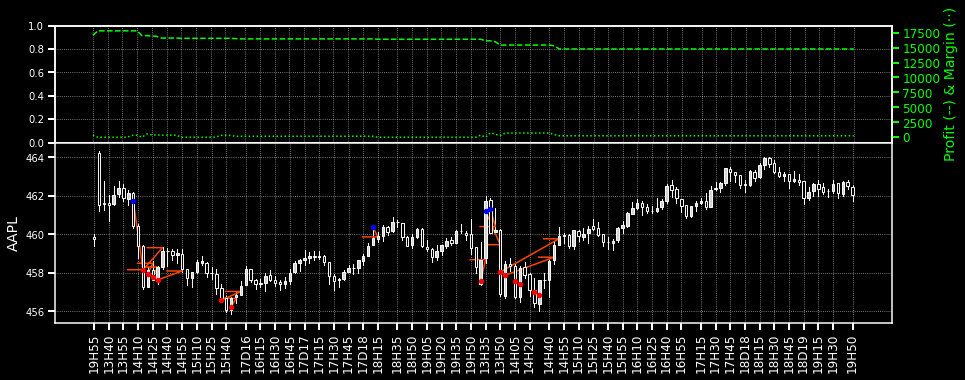

In [ ]:
t1, t2 = 0.50, 0.70
myTest = Backtest(name = "A certain strategy")  ;  myTest_unit_7(myTest)
Axes = myTest.plot_chart(symbol = symbol, t1 = t1, t2 = t2, signals = True, trades = True)
Axes.set_position(pos = [0.125, 0.125, 0.775, 0.500])  # After plotting, shrink axes to ~60% and lower them.
Axes.figure.add_axes([0.125, 0.625, 0.775, 0.325])   # Add a second subplot, of about ~40%, for profit/margin.
Axes.set_zorder(5)  ;  Axes2 = Axes.figure.axes[1] # Overlay main chart.
Axes = myTest.plot_balance(t1 = t1, t2 = t2, axes = Axes2)  # Plot profit/margin on upper, smaller subplot.

#### [{B}] Indicators

These are usually time series too, but may be of 2 ``metric`` types:
* <u>Absolute</u>: Measured in price units, therefore drawable on top of candlestick charts directly.
* <u>Relative</u>: Not measured in price units, Therefore may require a parallel graph. Some people call them "<u>oscillators</u>" as well.

Also, we've got more than one way on which graphical representation for an indicator shall we use:
* <u>Line</u>: a continuous trace. For continuous, single-valued indicators. <u>E.g.</u>: moving averages, RSIs, etc.
* <u>Fill</u>: a shading between two lines. For multi-valued indicators. <u>E.g.</u>: Bollinger bands, Stochastic, etc.
* <u>Scatter</u>: discrete markers. For discontinuous indicators. <u>E.g.</u>: Parabolic SAR, Fibonacci retracements, etc.

So...

1. Just in case, we extract all indicators from its column in our ``.Data``, between the specified row numbers "``t1``" & "``t2``".
2. After checking that the input ``label`` corresponds to an indicator indeed, we check whether an actual ``axes`` has been specified.
<br>&emsp;&ensp;In case it hasn't, we create new ``Figure``/``Axes`` for this particular graph. After this point, we should have an actual ``Axes`` ready.
3. We format this present ``Axes``' x-axis as timeline. If done once before, no problem in doing twice, as long as "``t1``" & "``t2``" didn't change.
4. Now, we disclose which type of graph do we want to plot. When we just specify...
<br>&emsp;&ensp;➔ A single ``label``: We are defining that our indicator is single valued. Then, we want to ``plot`` a normal line.
<br>&emsp;&ensp;➔ Two ``labels``: We are clarifying that our indicator is defined by two columns. Then, we want to ``fill`` the area ``_between`` these traces.

The "``**kwargs``" keyword allows us to add extra details to our graphic properties. For example, for color attributes.<br>But also, if we were to use markers ("``*``", "``o``", etc), <u>we could draw discontinuous</u> indicators very easily!

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"):
        super().__init__(name = name)
    def plot_indicator(self, labels, t1 = None, t2 = None, axes = None, **kwargs):
        t1, t2 = self._plot_time_error(t1, t2)  ### Format time arguments.
        if isinstance(labels, str): labels = [labels]
        X, Y_ind = range(t1, t2), self.Data["Indicators"].iloc[t1 : t2]  ### (1)
        Warn = "{INCL} 'labels' must be a string or list of strings already present in 'Indicator' block."
        assert all([(label in Y_ind.columns) for label in labels]), Warn
        if (axes != None): Axes = axes ### (2) Use input axes if specified.
        else: Figure, Axes = matplotlib.pyplot.subplots(); ### (2) Else, create new.
        axes_class = type(matplotlib.pyplot.gca())  ### Needed because axes' data type is too long to write.
        assert isinstance(Axes, axes_class), "{TYPE} 'axes' must be an axes from some already plotted figure."
        self._plot_timeline(axes = Axes, indexes = numpy.arange(t1, t2))  ### (3)
        matplotlib.pyplot.sca(Axes) ### Switch actual axes on, to receive future plots.
        if (len(labels) == 1):  ### (4)
            Axes.plot(X, Y_ind[labels[0]], label = labels[0], **kwargs);
        if (len(labels) == 2):  ### (4)
            Axes.fill_between(X, Y_ind[labels[0]], Y_ind[labels[1]], label = str(labels), **kwargs);
        Axes.legend()  ### To distinguish between different indicators.
        return Axes 

Let's try something in the same current as our most recent graphs. We plot...

1. The area between "``Env_H``" & "``Env_L``" (envelopes, absolute-valued) on top of the price chart. Low ``alpha`` gives some transparency.
2. The "``StDev``" and "``Wick``" width values (both relative-valued) in an upper parallel graph, as they are frequently compared in-strategy.

[*********************100%***********************]  1 of 1 completed


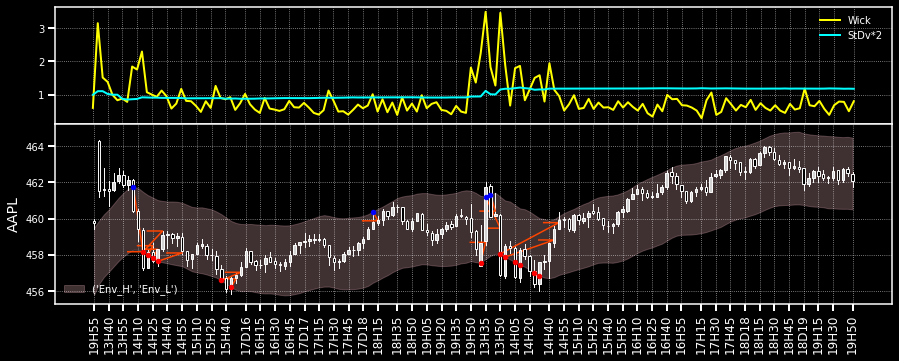

In [ ]:
myTest = Backtest(name = "A certain strategy")  ;  myTest_unit_7(myTest)
Axes = myTest.plot_chart(t1 = t1, t2 = t2, symbol = symbol, signals = True, trades = True);          ### (⇩1)
myTest.plot_indicator(t1 = t1, t2 = t2, labels = ("Env_H", "Env_L"), axes = Axes, color = "pink", alpha = 0.25)
Axes.set_position(pos = [0.125, 0.125, 0.775, 0.500]); # After plotting, shrink axes to ~60% and lower them.
Axes.figure.add_axes([0.125, 0.625, 0.775, 0.325]);    # Add 2nd subplot, of ~40%, for relative indicators.
Axes.set_zorder(5)  ;  Axes2 = Axes.figure.axes[1];    # Overlay main chart.
myTest.plot_indicator(t1 = t1, t2 = t2, axes = Axes2, lw = 2, color = "yellow", labels = "Wick"); ### (2)
myTest.plot_indicator(t1 = t1, t2 = t2, axes = Axes2, lw = 2, color = "cyan", labels = "StDv*%d" % n) ### (2)

#### [{C}] Trade distribution

It's usually depicted in barplots/histograms. Our proposal continues to be able to stack trades separately, according to our 3 profitability measuring units: ``point``s, ``profit``s ($) and ``ret``urns (%). As an additional utility, we may include a trade ``size`` histogram, which may give us an idea of if the trades that cause the most/least impact our balance, result from over/undersizing.

One may prefer to focus on a certain variable of those, and leave the others aside. So the next function basically defines how many histograms do we want to plot, and with which color. It is an ``_error`` checking function that assures that no invalid color is entered. No need to describe it thoroughly as it isn't that much important: just may help avoid some bugs.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"):
        super().__init__(name = name)
    def _plot_histogram_error(self, point, size, profit, ret):
        plots = {"point": point, "size": size, "profit": profit, "ret": ret}
        for plot in plots.keys():  # Check that each plot is activated with a correct word or input value.
            color, colors = plots[plot], list(matplotlib.colors.cnames.keys())
            assert isinstance(color, str) or isinstance(color, bool) or (color == None), "{TYPE} " \
                + f"'{plot}' argument must hold a string (color name) or True (random color) if used."
            plots[plot] = "" if (color == False) or (color == None) else color \
                if (color in colors) else colors[numpy.random.randint(0, 147)]
        n_plots = sum([bool(x) for x in plots.values()])
        assert (n_plots > 0), "{COND} at least one metric from (%s) must be activated" % list(plots.keys())
        return plots, n_plots

Our histograms may be focused on the trades done in a certain instrument ``symbol`` among a certain time interval (once again, defined by "``t1``" and "``t2``"). So both of these aspects are included as function arguments.

1. First, create the ``Figure`` in which we are going to be drawing. Declare as many ``subplots`` as variables we are measuring.<br>&emsp;&ensp;As all histograms measure "amount of stacked trades", they may ``share`` the same vertical axis for density measurement.
2. Then, we retrieve the ``Trades`` belonging to our chosen ``symbol`` and ``time`` interval.
3. We create a "``n_plots``" ``Axes``' counter which will switch ("``+1``") the different ``Axes`` of the subplots from left to right.
<br>&emsp;&ensp;This guarantees that each histogram is plotted on a different unique subplot, regardless of their measured variable.
4. Each histogram is drawn on the corresponding ``Axes`` if their activator held a valid color in the first place. Note that ``Return``s were formatted as string for being able to visualize its dataframe column in percentages (%). We need to turn them back to decimal numbers.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"):
        super().__init__(name = name)
    def plot_histogram(self, symbol, t1 = None, t2 = None, point = "green",
                       size = "teal", profit = None, ret = None, bins = 5):
        plots, n_plots = self._plot_histogram_error(point, size, profit, ret)
        Figure, Axes = matplotlib.pyplot.subplots(ncols = n_plots, sharey = True); ### (1)
        t1, t2 = self._plot_time_error(t1, t2)  ### Format time arguments.
        time_1, time_2 = self.Data.index[[t1, t2]]  ### Get datetime indexes.
        Trades = self.Trades[self.Trades["Sym"] == symbol]  ### (⇦2⇩)
        Trades = Trades.loc[(time_1 <= Trades["Time"]["Open"]) & (Trades["Time"]["Close"] <= time_2), :]
        n_plots = 0  ### (3)
        if plots["size"]:
            Axes[n_plots].hist(bins = bins, color = plots["size"], x = Trades["Size"]); ### (4)
            Axes[n_plots].set_title("Trade size")    ;    n_plots = n_plots + 1 ### (3)
        if plots["point"]:
            Axes[n_plots].hist(bins = bins, color = plots["point"], x = Trades["Points"][" "]); ### (4)
            Axes[n_plots].set_title("Points per trade")    ;    n_plots = n_plots + 1 ### (3)
        if plots["profit"]:
            Axes[n_plots].hist(bins = bins, color = plots["profit"], x = Trades["Profit"][" "]); ### (4)
            Axes[n_plots].set_title("Profit per trade")    ;    n_plots = n_plots + 1 ### (3)
        if plots["ret"]:
            Returns = [float(x[:-1])/100 for x in myTest.Trades["Return"][" "]]
            Axes[n_plots].hist(bins = bins, color = plots["ret"], x = Returns); ### (4)
            Axes[n_plots].set_title("Return per trade")    ;    n_plots = n_plots + 1 ### (3)
        return Figure

Let's try this last plot with all of the 4 variables included, throughout all times (no "``t1``" & "``t2``") and 30 frequency bins.

[*********************100%***********************]  1 of 1 completed


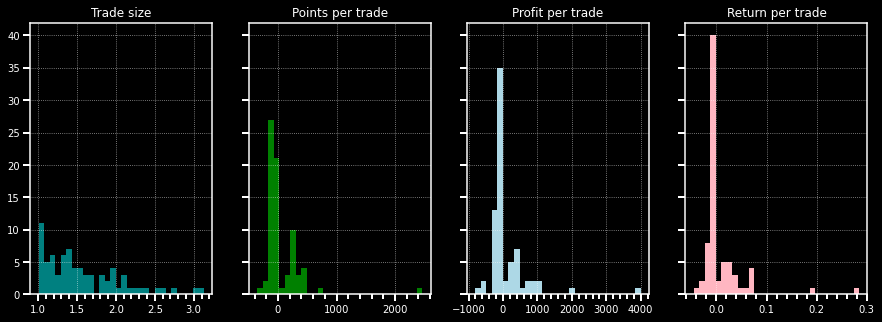

In [ ]:
myTest = Backtest(name = "A certain strategy")  ;  myTest_unit_7(myTest)
Figure = myTest.plot_histogram(myTest.Specs.columns[0], profit = True, ret = True, bins = 30)

Kinda useful to combine both chart and stats' dataframe in one sole figure as well, just for the sake of observing them in parallel.

[*********************100%***********************]  1 of 1 completed


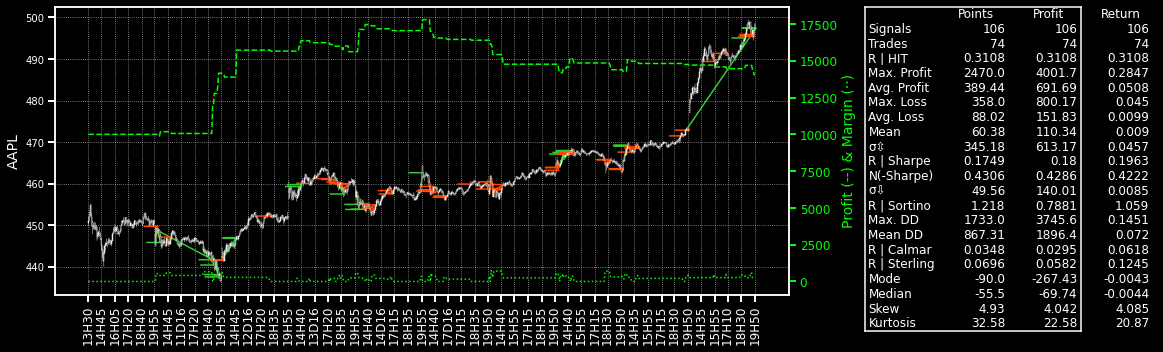

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"):
        super().__init__(name = name)
    def plot_complete(self, symbol, t1 = None, t2 = None, signals = False, trades = False, balance = False):
        AxChart = self.plot_chart(symbol, t1, t2, signals, trades, balance)
        AxChart.set_position(pos = [0.05, 0.1, 0.68, 0.8]);
        Figure = AxChart.figure
        Figure.set_figheight(Figure.get_figheight())
        AxTable = Figure.add_axes([0.8, 0, 0.2, 0.9])
        Stats = self.Stats[symbol]
        for m, n in enumerate([0, 1, 10, 1000, 10000]):
            f = lambda x: numpy.round(x*10**(4 - m))/10**(4 - m)
            Stats[2:] = Stats[2:].applymap(lambda x: x if (abs(x) <= n) else f(x))
        Table = AxTable.table(rowLabels = Stats.index, colLabels = Stats.columns, cellText = Stats.values,
                      cellColours = len(Stats.index)*[len(Stats.columns)*["black"]], bbox = [0.35, 0, 1, 1],
                      rowColours = len(Stats.index)*["black"], colColours = len(Stats.columns)*["black"])
        for n in range(len(Table.get_children())): Table.get_children()[n].set_fontsize(12)
        AxTable.set_xticks(ticks = [])  ;  AxTable.set_yticks(ticks = [])
        return Figure
# ------------------------------------------------------------------------- Let's try...
myTest = Backtest(name = "A certain strategy")  ;  myTest_unit_7(myTest)
Figure = myTest.plot_complete(symbol = symbol, signals = False, trades = True, balance = True);

### Before concluding...

#### [{A}] Make a copy

An additional small utility to create ``clone``s of the ``.Data``, so as to test new strategies without affecting the previous one's results. The thing is that we can't just equate the corresponding dataframe attributes between themselves. In reality, dataframe objects are just handles to a database, and if we do "``clone.Active = self.Active``", our ``clone`` would keep the handle and affect the original attribute. Therefore, we need to use the ``copy`` method of Pandas. Remember that "``[0:0]``" just keeps the dataframe columns, without the rows/content.

In [ ]:
class Backtest(Backtest):
    def __init__(self, name = "Strategy"):
        super().__init__(name = name)
    def clone(self, name = "A certain strategy"):
        name = name + ("" if (self.name != name) else "´") ## If name coincides with original, add a tilde.
        clone = Backtest(name = name)
        clone.Data = self.Data.copy() ## Make a copy of market data.
        clone.Data.drop(inplace = True, columns = self.Specs.columns) ## Delete signal columns.
        try: clone.Data.drop(inplace = True, columns = "Indicators")  ## Delete indicator column.
        except: x = 1
        for symbol in self.Specs.columns: ## Create signal columns again, but empty. One block for each symbol.
            clone.Data[(symbol, "Spread")] = self.Data[(symbol, "Spread")].copy() ## This should be identical.
            clone.Data[(symbol, "LB")] = None
            clone.Data[(symbol, "SS")] = None 
            clone.Data[(symbol, "LS")] = None
            clone.Data[(symbol, "SB")] = None
        clone.Specs = self.Specs.copy()
        clone.Active = self.Active.copy()[0:0] ## Copy results' dataframes but without rows: leave...
        clone.Trades = self.Trades.copy()[0:0] ## ...them just as blank, but keep the column labels.
        clone.Stats = self.Stats.copy()[0:0]
        return clone

#### A small disclaimer

At **no time in this document** were we ever trying to design a profittable strategy. So please, do not pay close attention to the profitability results. Except for their ease of interpretation in each dataframe and figure, they should be seen as (at least financially) meaningless.

<br>
<hr>

### Conclusions

So our backtesting framework is somewhat complete enough to backtest a wide range of strategies. It possesses pretty much all the elements we've seen in the lectures about event-oriented backtesting (specially DMP 3 to 5). It's capable of being applied pretty much to almost all of the technical-analysis-driven strategies like the one presented here (EFS 1 & 2), and though it's yet to be proven, it may be also adequate enough for methodologies with a more statistical or regressive nature (ASQ 1 & 2). For machine learning predictor (MLT 1 to 4), an external deep learning module such as an already trained neural network, shall be built and then applied to this systems.

I would also like to remark (again) that the advantage of having the portfolio evaluation metrics (PRM 1) calculated both in ``point`` and ``currency`` quantities besides ``returns``, allows the trader to measure the worthiness of its trade sizing methodology, which is extremely important in retail trading.

I think that the main advantage of this system, is that it has a lot of potential for modelling real results with an accuracy almost identical to a real sequential backtester such as the one designed by MetaTrader 5 itself (which <u>unfortunately does not accept Python</u> projects, but C/C++). Also it aims to pay close attention to impacts on margin, which MetaTrader 5 also does but does not really keep a precise record of it (just interrupts the backtesting process when margin is too high to simulate new trades). 

The multi-instrument implementation may prove useful for statistical arbitrage systems (MLT 4). It has yet to be tested, but may be possible if calculating the cointegrated time series (to be found from pairs in dataset) as a column inside the indicator section. Then, a procedural strategy such as the ones presented may be developed and tested.

This framework also leaves space for a wide range of improvements and additional features to be implemented:
* A **trailing stop** system which adjusts ``SL`` and ``SP`` values according to data progression. May consist in two additional functions inside the "``StopInfo``" ``dict`` which are executed during the "``test_strategy``" timeline, for each opened trade which does hold a "``SL``"/"``SP``". Such functions may grab each ``.Active`` trades' values and each ``.Data`` row's context, and return a new "``SL``"/"``SP``" price to be updated.
* The usage of **pending orders** (buy/limit) that trigger when a certain opening price is reached. This one may require an additional ``.Pending`` dataframe, similar to the one for ``.Active`` trades. Also it can be coded in the same vein as the "``_close_by_stop``" but the other way around: triggering an open (execution) instead of a close (exit).
* Some **computational delay measurement** system could be implemented. Similar to the "``%timeit``" magic keyword in Jupyter Notebooks, but applied to certain calculations: indicators, signals and stop values. These 3 objects may be the ones which require the most complex and synchronous operations and data processing in real time, as seen in the course. Measurements could then be compared with the real amount of time included in ``.Data``, to detect computational performance weakpoints.
* **Other data providers** outside from MetaTrader 5 could be called upon. Yahoo! Finance, Quandl, Binance, or other brokerage platforms do have Python libraries for downloading data directly, so it's just a matter of creating additional functions exactly equal to "``_download_data``" but with the library's downloader method in place of MetaTrader's "``copy_rates_from``".
* A **parameter optimizer** could be designed if for any indicator or signal or StopInfo dict that we coded, we declared a certain parameter (e.g.: period in envelopes, number of standard deviations, etc.) as a symbolic entity to be iterated upon, trying to induce a profitability maximum or similar concerns. May consume some computational resources, as this framework is already somewhat heavy. It's worth to look upon, however.

Perhaps the most important result of this particular task, is the fact that the capability of calculating profits and returns solely based in differential trade outcomes has been demonstrated. At least for me, the entity that we call ``point`` is the main prize for us traders, rather than ``dollar``. Closing a successful trade means closing a trade that has captured a market movement. Market movement is always measured in terms of points. And what we are really trying to do is to predict market movements, to profit on them.

Yes, focusing on earning points does give us an explicit idea of our system's financial profitability, given that it's only a matter of some calculations (as already seen: involving trade sizes and lot values) to convert points to profit or returns. But more important is that our "score" in points indicate the **real predictive power** of the algorithm. And that's quite useful...

#### Final remark

Just in case, I'll repeat that this work has been written in a Jupyter Notebook for easy read and understanding of each block. I wanted to keep each function/method **as partitioned as possible**, to be able to read them in small cells and understand them better with their descriptions in markdown being nearby enough. This is specially taking into consideration its "academic" and "educational" approach, as a final project. However...
* It can be imported as a little "library" by the use of the "``ipynb``" Python package, for use in other files. It will be in fact, used for the course's backtesting practice exercises attached to this project.
* Though the direct execution of this file may run a bit slow for dataframes of as small as 1000 rows, please consider that this file runs the backtesting process for about 7 "``myTest_units``" and around 4 or 5 additional plots (pretty much each time we incorporate a new method). In real applications, should run much faster.
* It may run **much, much faster** if written in "``.py``" as a single class declaration. That is easily done with a IPython-to-Python code converter, and then deleting all "``def __init__()``" and "``super()``" incidences (except the first declaration of all, of course).

<div align = "right"><b><u>Hope you liked this task. Thanks for reading!!!</u></b></div>